# **Market Risk — VaR, ES, and Copulas**

**Names of all group members:**
- Philipp Mayer (philipp.mayer@epfl.ch)
- Rafael Barroso (rafael.barroso@epfl.ch)
---

## **Part 0 - Setup**

In [1]:
import os
import numpy as np
import copulae
import math
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib import gridspec

from dataclasses import dataclass
from typing import Dict, Tuple
from pathlib import Path

from scipy.stats import jarque_bera
from scipy.stats import t as student_t
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import t as t_stud
from scipy.stats import chi2
import scipy.stats as stats

In [2]:
# Locate the Project 1 directory to this notebook's working directory
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / 'data'      # Use Path division operator
OUT_DIR = PROJECT_DIR / 'output'     # Use Path division operator

for d in [DATA_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Parameters
TICKERS = ['AAPL', 'META', 'JPM']   # list of tickers
START = '2023-01-01'                # start date for data download
END = '2025-06-30'                  # end date for data download
WINDOW = 252                        # rolling/first-window length in periods (days)
ALPHAS = [0.95, 0.99]               # list of confidence levels
np.random.seed(0)

print('Project dir:', PROJECT_DIR) 

print('Downloading data to', DATA_DIR)
for t in TICKERS:
    print(f'  -> {t}')
    df = yf.download(t, start=START, end=END, progress=False, auto_adjust=False)
    if df.empty:
        print(f'     Warning: no data for {t}')
        continue
    out = df.reset_index()
    out = out[['Date', 'Adj Close']]
    out.to_csv(DATA_DIR / f'{t}.csv', index=False)
print('Done.')

Project dir: /home/rafiki/Documents/Quantitative-Risk-Management---Project-1
  -> AAPL
  -> META
  -> JPM
Done.


In [3]:
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith('.csv')]
frames = []
for f in files:
    p = os.path.join(DATA_DIR, f)
    df = pd.read_csv(p, parse_dates=['Date'])
    df = df[['Date', 'Adj Close']]
    # Coerce to numeric and drop malformed rows
    df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
    df = df.dropna(subset=['Date', 'Adj Close'])
    df = df.rename(columns={'Adj Close': f.split('.')[0]})
    df = df.set_index('Date').sort_index()
    frames.append(df)
prices = pd.concat(frames, axis=1).dropna(how='all')

print(prices.head())

                   JPM        META        AAPL
Date                                          
2023-01-03  125.492218  123.975723  123.211212
2023-01-04  126.662460  126.589615  124.482033
2023-01-05  126.634384  126.162254  123.161957
2023-01-06  129.057632  129.223389  127.693573
2023-01-09  128.524277  128.676743  128.215683


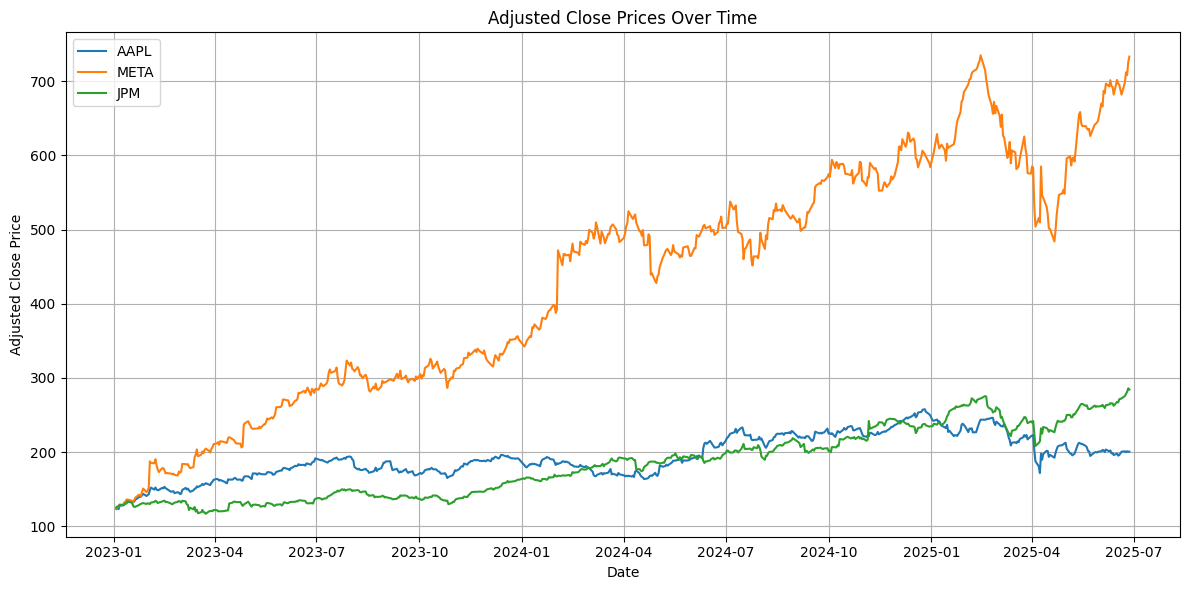

In [4]:
# Visualize the prices over time

plt.figure(figsize=(12, 6))
for ticker in TICKERS:
    if ticker in prices.columns:
        plt.plot(prices.index, prices[ticker], label=ticker)
plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Part 1 - Empirical Stylyzed facts**

### 1.1 - Computing returns

In [5]:
# Compute log-returns
returns = np.log(prices / prices.shift(1)).dropna(how='all')
returns = returns.dropna()  # Drop rows with any NaN values
returns.columns = TICKERS
print(returns.head())

losses = - returns
print(losses.head())

                AAPL      META       JPM
Date                                    
2023-01-04  0.009282  0.020865  0.010261
2023-01-05 -0.000222 -0.003382 -0.010661
2023-01-06  0.018955  0.023974  0.036133
2023-01-09 -0.004141 -0.004239  0.004080
2023-01-10  0.008914  0.026825  0.004447
                AAPL      META       JPM
Date                                    
2023-01-04 -0.009282 -0.020865 -0.010261
2023-01-05  0.000222  0.003382  0.010661
2023-01-06 -0.018955 -0.023974 -0.036133
2023-01-09  0.004141  0.004239 -0.004080
2023-01-10 -0.008914 -0.026825 -0.004447


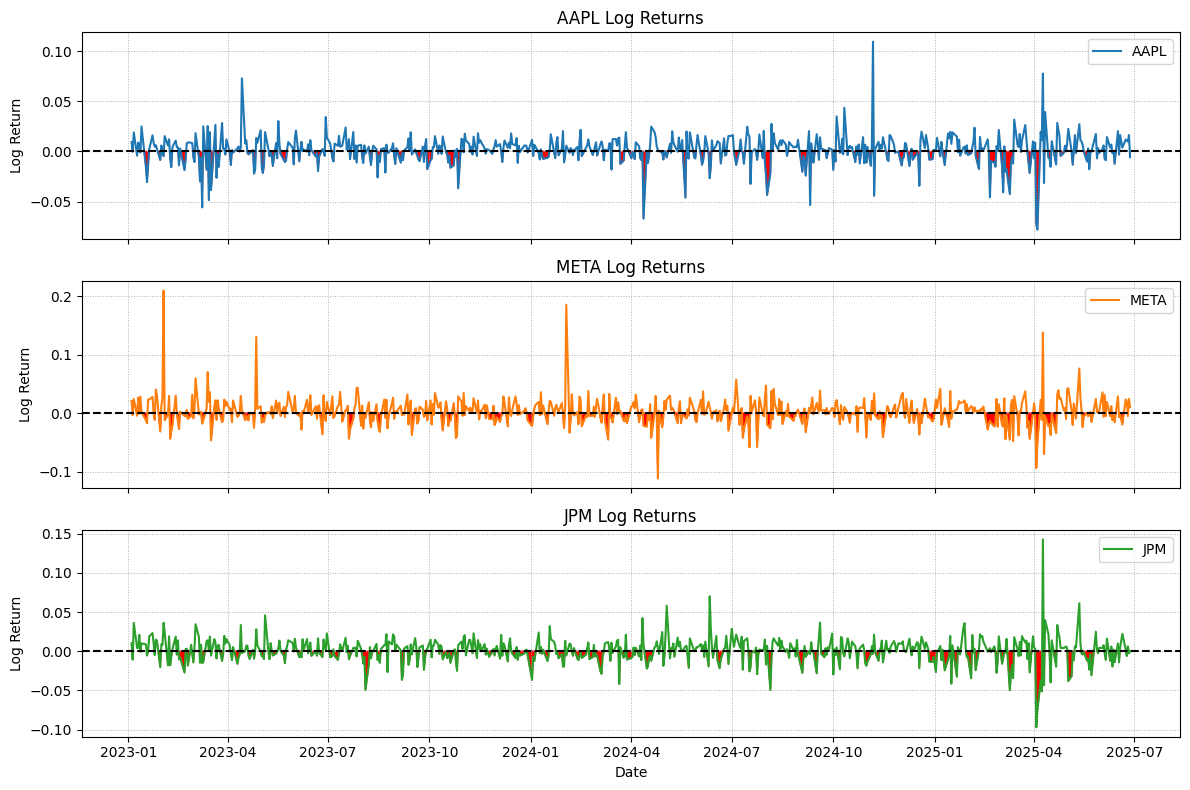

In [6]:
# Plot the returns over time
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(12, 8), sharex=True)

for i, ticker in enumerate(TICKERS):
    if ticker in returns.columns:
        axes[i].plot(returns.index, returns[ticker], label=ticker, color=f'C{i}')
        
        # Add horizontal zero line
        axes[i].axhline(0, color='black', linewidth=1.5, linestyle='--')
        
        # Shade regions where returns are negative
        axes[i].fill_between(
            returns.index,
            returns[ticker],
            0,
            where=(returns[ticker] < 0),
            color='red',
            alpha=1,
            interpolate=True
        )
        
        axes[i].set_title(f'{ticker} Log Returns')
        axes[i].set_ylabel('Log Return')
        axes[i].grid(True, linestyle=':', linewidth=0.7)
        axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

      Annual Scaled Volatility  Mean Rolling Volatility
AAPL                  0.236728                 0.217996
META                  0.381731                 0.353165
JPM                   0.262235                 0.239078


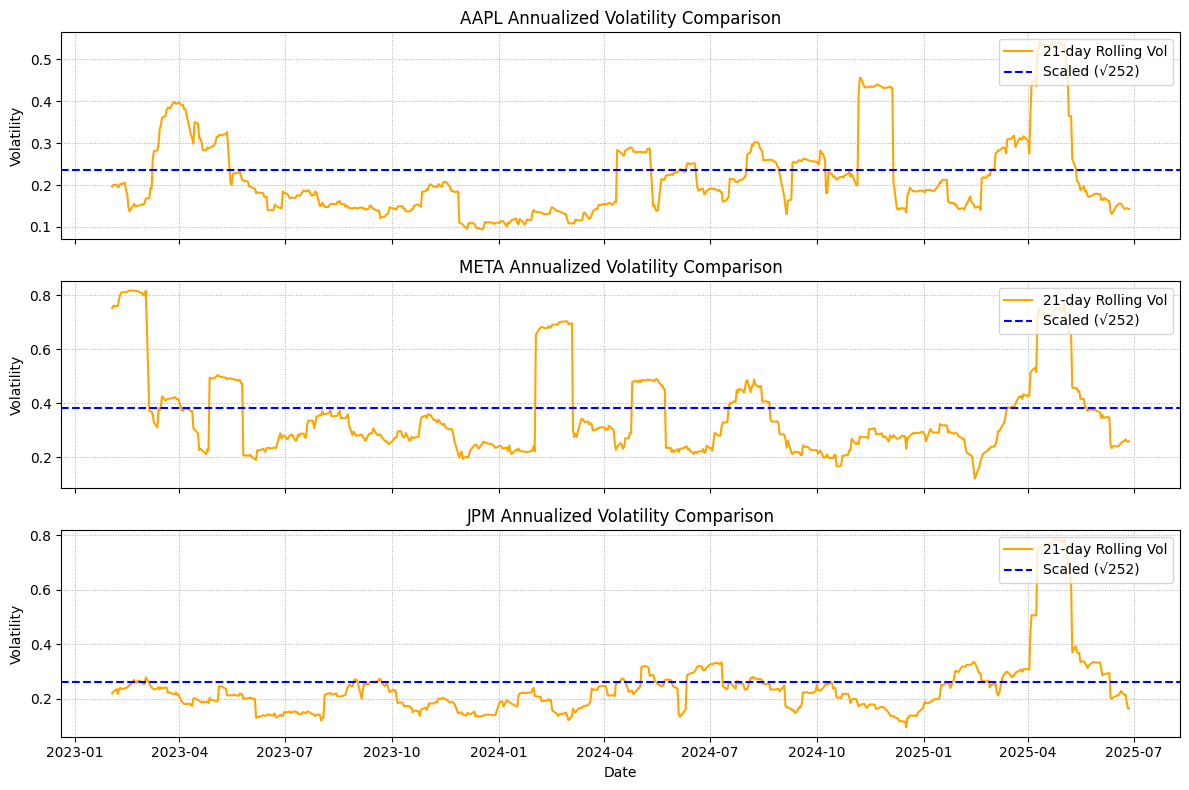

In [7]:
# Anual volatility and rolling volatility
ann_vol = returns.std() * np.sqrt(252) # Annualized volatility; 252 trading days in a year

rolling_vol = returns.rolling(window=21).std() * np.sqrt(252) # 21 trading days in a month
mean_rolling_vol = rolling_vol.mean()

vol_comparison = pd.DataFrame({
    'Annual Scaled Volatility': ann_vol,
    'Mean Rolling Volatility': mean_rolling_vol
})

print(vol_comparison)

fig, axes = plt.subplots(len(TICKERS), 1, figsize=(12, 8), sharex=True)

for i, ticker in enumerate(TICKERS):
    axes[i].plot(rolling_vol.index, rolling_vol[ticker], label='21-day Rolling Vol', color='orange')
    axes[i].axhline(ann_vol[ticker], color='blue', linestyle='--', label='Scaled (√252)')
    axes[i].set_title(f'{ticker} Annualized Volatility Comparison')
    axes[i].set_ylabel('Volatility')
    axes[i].grid(True, linestyle=':', linewidth=0.7)
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [8]:
# Obtain statistical metrics for the returns
stats_vol = rolling_vol.describe().T
print(stats_vol)

      count      mean       std       min       25%       50%       75%  \
AAPL  602.0  0.217996  0.097758  0.093527  0.147330  0.187831  0.260369   
META  602.0  0.353165  0.156326  0.120385  0.241420  0.294384  0.409103   
JPM   602.0  0.239078  0.114443  0.095847  0.174812  0.220553  0.261877   

           max  
AAPL  0.542320  
META  0.818103  
JPM   0.784333  


### 1.2 - Visualizing dependencies

In [9]:
# Computation of cross-correlations and auto-correlations
max_lag = 25

correlation_returns = {}
absolute_correlation_returns = {}

cols_now = [f"now_{c}" for c in returns.columns]
cols_lag = [f"lag_{c}" for c in returns.columns]

for lag in range(max_lag + 1):

    R_now = returns.add_prefix("now_")
    R_lag = returns.shift(lag).add_prefix("lag_")

    # Correlation matrix of [now | lag] and take the cross block
    M = pd.concat([R_now, R_lag], axis=1).corr()
    C = M.loc[cols_now, cols_lag]              # shape: (n_assets, n_assets)
    correlation_returns[lag] = C         # rows: now_i, cols: lag_j

    # Absolute version
    M_abs = pd.concat([R_now.abs(), R_lag.abs()], axis=1).corr()
    C_abs = M_abs.loc[cols_now, cols_lag]
    absolute_correlation_returns[lag] = C_abs



correlation_returns_df = pd.DataFrame({k: C.stack() for k, C in correlation_returns.items()})
correlation_returns_df = correlation_returns_df.T

absolute_correlation_returns_df = pd.DataFrame({k: C.stack() for k, C in absolute_correlation_returns.items()})
absolute_correlation_returns_df = absolute_correlation_returns_df.T

In [10]:
correlation_returns_df

now_AAPL                      now_META                       now_JPM  \
    lag_AAPL  lag_META   lag_JPM  lag_AAPL  lag_META   lag_JPM  lag_AAPL   
0   1.000000  0.287953  0.327717  0.287953  1.000000  0.464631  0.327717   
1  -0.024355  0.011660 -0.018269 -0.038186 -0.030284 -0.054078  0.052208   
2   0.079992  0.056359  0.035226  0.043752 -0.033861 -0.032970  0.153718   
3  -0.073262 -0.020381 -0.138621 -0.085723 -0.006730 -0.108426 -0.066794   
4  -0.041629 -0.077618 -0.108099 -0.073195 -0.032511 -0.020490 -0.019617   
5   0.035549  0.030884 -0.009209  0.005573  0.000117 -0.026305  0.006641   
6  -0.032685  0.034181 -0.002813  0.047379 -0.011827  0.013884 -0.014124   
7   0.022317  0.012222  0.013464  0.005648  0.031723  0.051616 -0.050695   
8  -0.082146 -0.001184  0.048663  0.009265  0.009282  0.074067 -0.018142   
9   0.039544  0.007072 -0.007184  0.063411  0.022978  0.044964 -0.019114   
10 -0.029210 -0.017617 -0.011530  0.032984  0.015694 -0.011224 -0.018752   
11  0.049998  0.012444 -0.001088 -0.012779 -0.034077  0.012625 -0.053911   
12 -0.023289  0.027083 -0.001916  0.002385  0.005002 -0.064274  0.015260   
13 -0.015934  0.037543  0.037422  0.015549 -0.001734 -0.018868 -0.018784   
14 -0.019215  0.030674 -0.026466 -0.064741 -0.040572 -0.034009 -0.048999   
15  0.025337 -0.001124 -0.023544 -0.012379  0.000305  0.026798  0.005812   
16  0.009728 -0.004971  0.028893 -0.023699 -0.010795 -0.019676 -0.034736   
17 -0.062656 -0.038970 -0.080086  0.022200 -0.007022 -0.019794 -0.046364   
18  0.056863  0.005101  0.010570  0.050432 -0.005441  0.063723  0.035364   
19 -0.084317 -0.103912 -0.031436 -0.009920 -0.001879 -0.066292  0.042217   
20  0.074577  0.058031  0.074214 -0.006672  0.066173  0.004204  0.112832   
21 -0.064080  0.000457 -0.043745  0.002800 -0.012255 -0.018813  0.013304   
22 -0.024613 -0.032740  0.044011  0.050217  0.005579  0.018771  0.067515   
23  0.013003  0.039554  0.014492 -0.005720  0.008592 -0.035944  0.024040   
24 -0.013998 -0.056162 -0.027823  0.022609  0.059689  0.039560 -0.014471   
25 -0.053870  0.006256 -0.002534 -0.024288 -0.062116 -0.025685 -0.047559   

                        
    lag_META   lag_JPM  
0   0.464631  1.000000  
1   0.024540  0.031829  
2   0.069184  0.073662  
3  -0.013648 -0.057765  
4  -0.033070 -0.067542  
5   0.011659 -0.090661  
6   0.010801  0.010198  
7   0.012858 -0.020860  
8  -0.015558  0.004104  
9  -0.007647  0.043840  
10 -0.033295 -0.017092  
11 -0.014784 -0.009471  
12 -0.020911 -0.031418  
13  0.073464  0.043540  
14  0.030248 -0.035477  
15  0.012332  0.022987  
16 -0.067880 -0.069288  
17 -0.053327 -0.040684  
18 -0.019584  0.059867  
19 -0.051428  0.011128  
20  0.111730  0.089671  
21  0.027197 -0.021330  
22 -0.033314  0.066776  
23  0.038097  0.011306  
24  0.005799 -0.038571  
25  0.001581 -0.046087

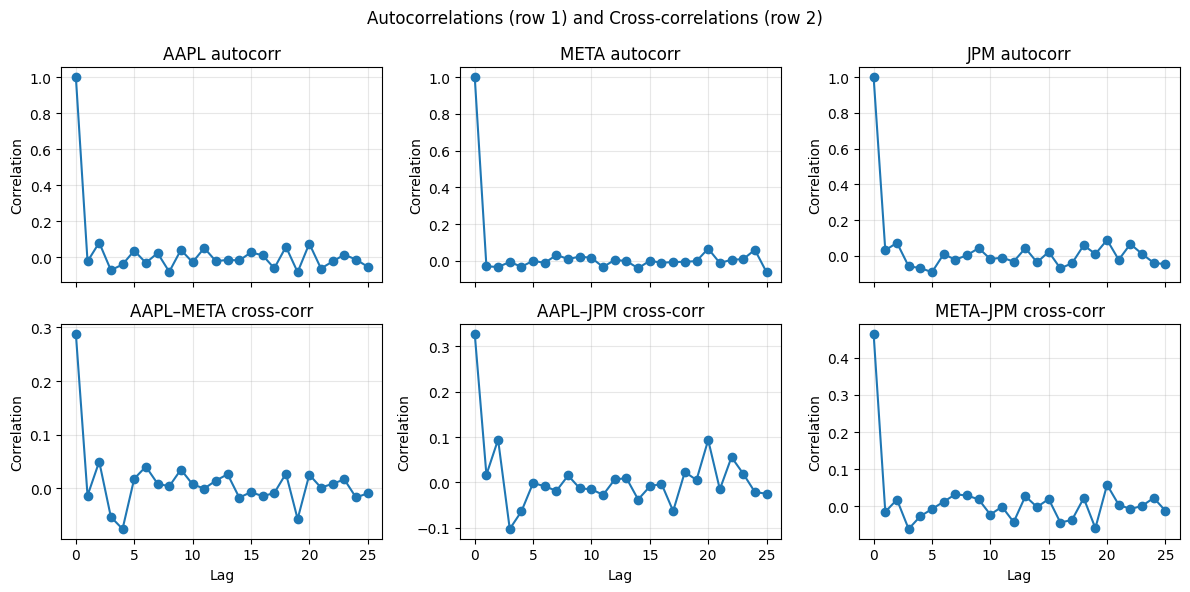

In [11]:
# Ploting raw correlations
## Extract lag index
lags = correlation_returns_df.index

## Autocorr (diagonal) 
auto = {
    "AAPL": correlation_returns_df[("now_AAPL", "lag_AAPL")],
    "META": correlation_returns_df[("now_META", "lag_META")],
    "JPM":  correlation_returns_df[("now_JPM",  "lag_JPM")],
}

## Cross-corr (average both directions per pair) 
cross = {
    "AAPL–META": 0.5 * (correlation_returns_df[("now_AAPL", "lag_META")]
                       + correlation_returns_df[("now_META", "lag_AAPL")]),
    "AAPL–JPM":  0.5 * (correlation_returns_df[("now_AAPL", "lag_JPM")]
                       + correlation_returns_df[("now_JPM",  "lag_AAPL")]),
    "META–JPM":  0.5 * (correlation_returns_df[("now_META", "lag_JPM")]
                       + correlation_returns_df[("now_JPM",  "lag_META")]),
}

## Plot: 2 rows × 3 cols 
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

### Row 1: autocorrelations (one asset per subplot)
for ax, (label, series) in zip(axes[0], auto.items()):
    ax.plot(lags, series, marker="o")
    ax.set_title(f"{label} autocorr")
    ax.grid(alpha=0.3)
    ax.set_ylabel("Correlation")

### Row 2: cross-correlations (one pair per subplot)
for ax, (label, series) in zip(axes[1], cross.items()):
    ax.plot(lags, series, marker="o")
    ax.set_title(f"{label} cross-corr")
    ax.grid(alpha=0.3)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Correlation")

fig.suptitle("Autocorrelations (row 1) and Cross-correlations (row 2)", y=0.98)
plt.tight_layout()
plt.show()

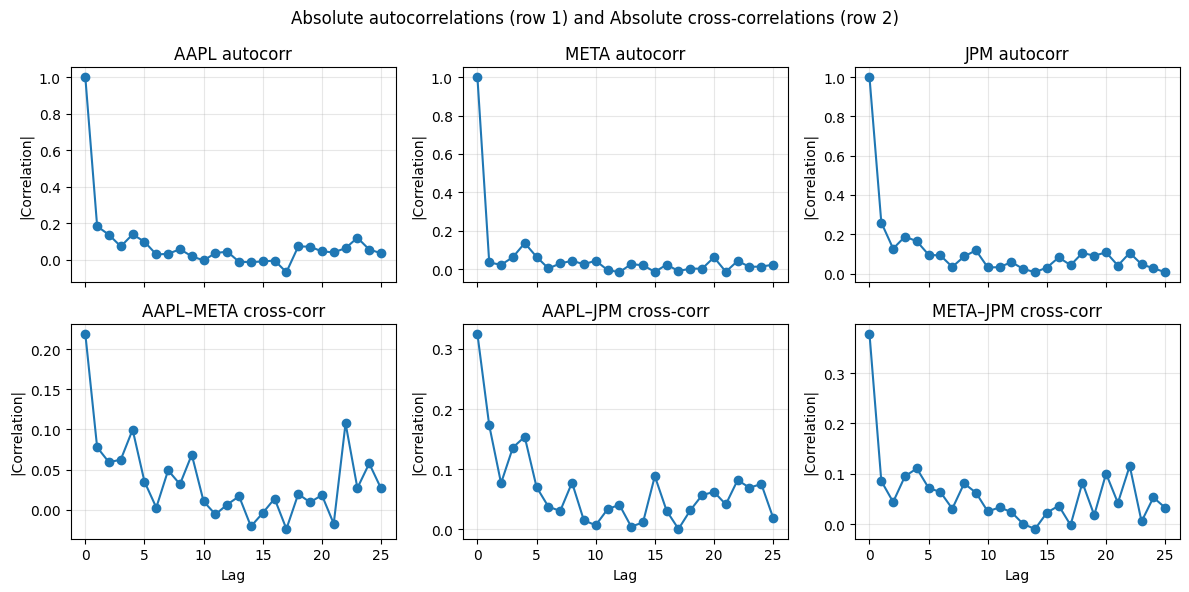

In [12]:
# Ploting absolute correlations
## Extract lag index
lags = absolute_correlation_returns_df.index

## Autocorr (diagonal) 
auto = {
    "AAPL": absolute_correlation_returns_df[("now_AAPL", "lag_AAPL")],
    "META": absolute_correlation_returns_df[("now_META", "lag_META")],
    "JPM":  absolute_correlation_returns_df[("now_JPM",  "lag_JPM")],
}

## Cross-corr (average both directions per pair) 
cross = {
    "AAPL–META": 0.5 * (absolute_correlation_returns_df[("now_AAPL", "lag_META")]
                       + absolute_correlation_returns_df[("now_META", "lag_AAPL")]),
    "AAPL–JPM":  0.5 * (absolute_correlation_returns_df[("now_AAPL", "lag_JPM")]
                       + absolute_correlation_returns_df[("now_JPM",  "lag_AAPL")]),
    "META–JPM":  0.5 * (absolute_correlation_returns_df[("now_META", "lag_JPM")]
                       + absolute_correlation_returns_df[("now_JPM",  "lag_META")]),
}

## Plot 
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

### Row 1: autocorrelations (one asset per subplot)
for ax, (label, series) in zip(axes[0], auto.items()):
    ax.plot(lags, series, marker="o")
    ax.set_title(f"{label} autocorr")
    ax.grid(alpha=0.3)
    ax.set_ylabel("|Correlation|")

### Row 2: cross-correlations (one pair per subplot)
for ax, (label, series) in zip(axes[1], cross.items()):
    ax.plot(lags, series, marker="o")
    ax.set_title(f"{label} cross-corr")
    ax.grid(alpha=0.3)
    ax.set_xlabel("Lag")
    ax.set_ylabel("|Correlation|")

fig.suptitle("Absolute autocorrelations (row 1) and Absolute cross-correlations (row 2)", y=0.98)
plt.tight_layout()
plt.show()

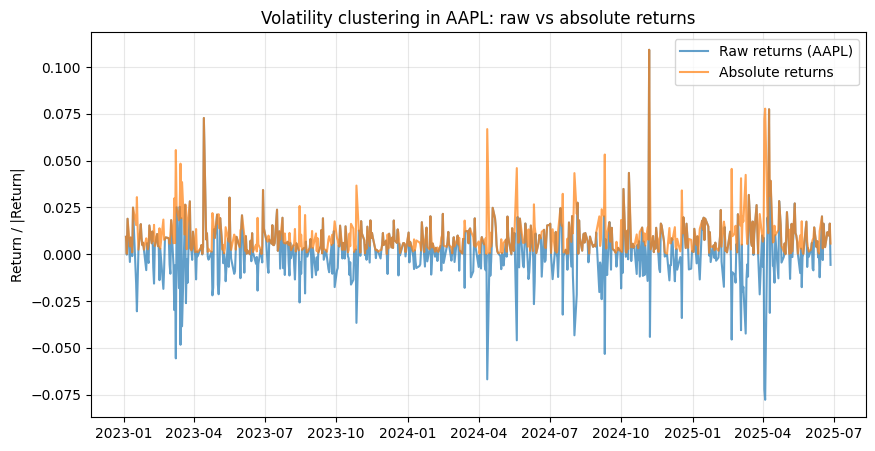

In [13]:
plt.figure(figsize=(10,5))
plt.plot(returns.index, returns['AAPL'], label='Raw returns (AAPL)', alpha=0.7)
plt.plot(returns.index, returns['AAPL'].abs(), label='Absolute returns', alpha=0.7)
plt.legend()
plt.title("Volatility clustering in AAPL: raw vs absolute returns")
plt.ylabel("Return / |Return|")
plt.grid(True, alpha=0.3)
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_140792/553915919.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Rolling $\sigma$")


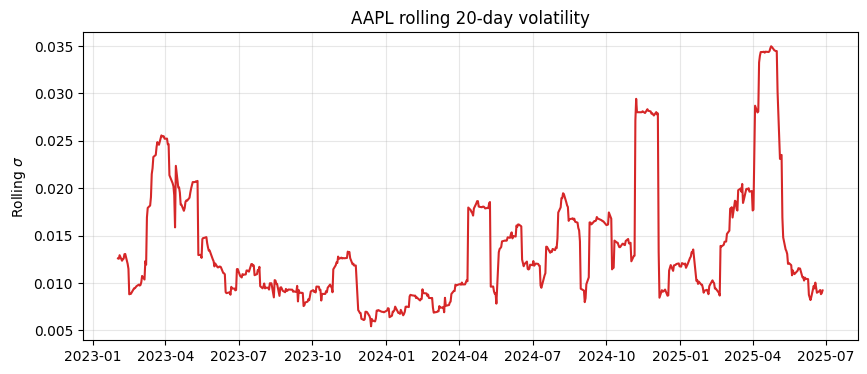

In [14]:
window = 20 
rolling_vol = returns['AAPL'].rolling(window).std()

plt.figure(figsize=(10,4))
plt.plot(returns.index, rolling_vol, color='tab:red')
plt.title(f"AAPL rolling {window}-day volatility")
plt.ylabel("Rolling $\sigma$")
plt.grid(alpha=0.3)
plt.show()


### 1.3 - Testing dependencies

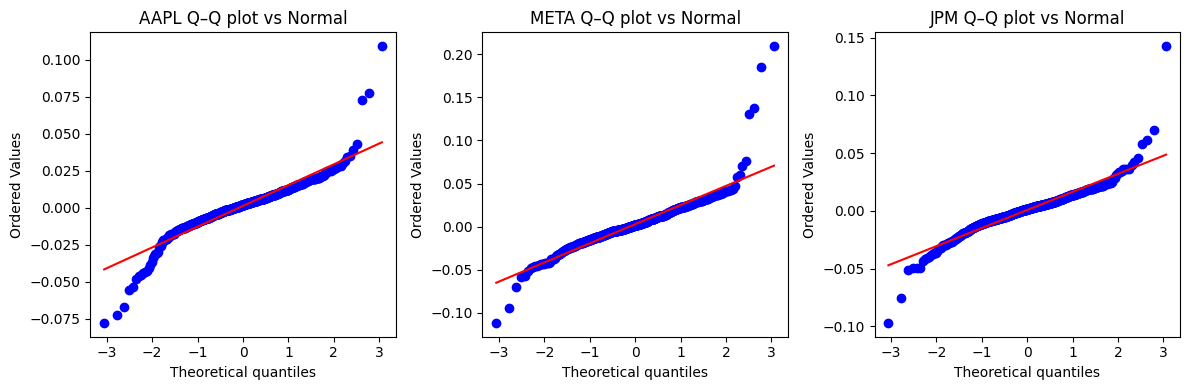

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, asset in zip(axes, TICKERS):
    stats.probplot(returns[asset], dist="norm", plot=ax)
    ax.set_title(f"{asset} Q–Q plot vs Normal")
    ax.get_lines()[1].set_color('red')  # line of best fit

plt.tight_layout()
plt.show()

In [16]:
for asset in TICKERS:
    jb_stat, p_value = jarque_bera(returns[asset])
    print(f"{asset}: JB = {jb_stat:.3f}, p-value = {p_value:.5f}")
    if p_value < 0.05:
        print(" -> Reject normality (non-normal distribution)\n")
    else:
        print(" -> Fail to reject normality (consistent with normal)\n")

AAPL: JB = 2203.507, p-value = 0.00000
 -> Reject normality (non-normal distribution)

META: JB = 7608.780, p-value = 0.00000
 -> Reject normality (non-normal distribution)

JPM: JB = 3619.278, p-value = 0.00000
 -> Reject normality (non-normal distribution)



## **Part 2 - First window modelling**

### Implementation of the models

In [17]:
W = 252  # approx. one trading year

def select_window_and_losses(returns: pd.DataFrame, tickers=('AAPL','META','JPM'), W: int = 252) -> pd.DataFrame:
    """
    Take the first W observations of log-returns for the given tickers and return a DataFrame of losses (L = -R).
    This function keeps column names unchanged (tickers) and aligns dates.
    """
    sub = returns.loc[:, list(tickers)].iloc[:W].copy()
    losses = -sub  # right-tail risk
    losses.columns = list(tickers)
    return losses

losses_W = select_window_and_losses(returns)
losses_W.head()

AAPL      META       JPM
Date                                    
2023-01-04 -0.009282 -0.020865 -0.010261
2023-01-05  0.000222  0.003382  0.010661
2023-01-06 -0.018955 -0.023974 -0.036133
2023-01-09  0.004141  0.004239 -0.004080
2023-01-10 -0.008914 -0.026825 -0.004447

In [18]:
# Statistical fits

@dataclass
class FitResult:
    model: str                 # 'historical' | 'gaussian' | 'student_t' | 'AR_GARCH'
    params: Dict[str, float]   # e.g., {'mu': ..., 'sigma': ...} or {'nu': ..., 'mu': ..., 'sigma': ...}

def fit_historical(losses: pd.Series) -> FitResult:
    return FitResult(model='historical', params={})

def fit_gaussian(losses: pd.Series) -> FitResult:
    mu = float(losses.mean())
    sigma = float(losses.std(ddof=1))
    return FitResult(model='gaussian', params={'mu': mu, 'sigma': sigma})

def fit_student_t(losses: pd.Series) -> FitResult:
    # scipy's t.fit returns (nu, loc, scale) via MLE. We do not fix parameters, to keep it general.
    nu, loc, scale = student_t.fit(losses) # <-- changed that
    return FitResult(model='student_t', params={'nu': float(nu), 'mu': float(loc), 'sigma': float(scale)})

def fit_AR_GARCH(losses_W: pd.DataFrame, p=(1, 1, 1)) -> Dict:
    # Necessary imports
    try:
        from statsmodels.tsa.ar_model import AutoReg
        from arch import arch_model
    except ImportError as err:
        print(f"Import failed in 'forecast_AR_GARCH: {err}.")
    
    # Build return dictionnary
    res = {col_name: {'mu': 0.0, 'sigma': 0.0} for col_name in losses_W.columns}

    # Perform for evey ticker
    for idx, ticker in enumerate(losses_W.columns):
        series = losses_W[ticker].values

        # Fit AR model and get the residuals
        ar_fitted = AutoReg(series, lags=p[idx], old_names=False).fit()
        residuals = ar_fitted.resid        

        # Fit the HARCH(1,1) to the residuals
        garch_fitted = arch_model(residuals, vol='Garch', p=1, q=1, dist='normal', rescale=False).fit(disp='off')
        
        # Store results
        res[ticker]['mu'] = ar_fitted.forecast(steps=1)[0]
        res[ticker]['sigma'] = np.sqrt(garch_fitted.forecast(horizon=1).variance.values[-1, 0])

    return res

def fit_AR_GARCH(losses_W: pd.DataFrame, p: Tuple[int, ...] = (1,1,1)) -> Dict[str, Dict[str, float]]:
    """
    Fit AR(p) + GARCH(1,1) per ticker.
    Returns dict with one-step-ahead forecasts for mu and sigma.
    
    KEY FIX: Manually normalize residuals for GARCH stability, then rescale forecast back.
    This avoids the incorrect double-scaling that rescale=True introduces.
    """
    try:
        from statsmodels.tsa.ar_model import AutoReg
        from arch import arch_model
    except ImportError as err:
        raise ImportError(f"Required packages not found: {err}")
    
    res = {col: {'mu': 0.0, 'sigma': 0.0} for col in losses_W.columns}
    for idx, ticker in enumerate(losses_W.columns):
        series = losses_W[ticker].values
        
        # Fit AR model
        ar_fitted = AutoReg(series, lags=p[idx], old_names=False).fit()
        mu_ahead = float(ar_fitted.forecast(steps=1)[0])
        residuals = ar_fitted.resid
        
        # Manually normalize residuals for numerical stability
        resid_std = np.std(residuals, ddof=1)
        resid_normalized = residuals / resid_std
        
        # Fit GARCH(1,1) on normalized residuals with rescale=False
        garch_fitted = arch_model(
            resid_normalized, 
            vol='Garch', 
            p=1, 
            q=1, 
            dist='normal', 
            rescale=False  # We handle scaling ourselves
        ).fit(disp='off')
        
        # Get one-step-ahead variance forecast (on normalized scale)
        variance_normalized = garch_fitted.forecast(horizon=1).variance.values[-1, 0]
        
        # Rescale back to original residual scale
        # If X_normalized = X / std(X), then Var(X) = Var(X_normalized) * std(X)^2
        sigma_ahead = np.sqrt(variance_normalized) * resid_std
        
        # Store results
        res[ticker]['mu'] = mu_ahead
        res[ticker]['sigma'] = sigma_ahead
    
    return res


In [19]:
# Workarounds

def one_ticker_var_es_gaussian(mu: float, sigma: float, alpha: float) -> Tuple[float, float]:
    """Closed-form VaR/ES for Normal(mu, sigma). VaR_alpha is the alpha-quantile (right tail is risky)."""
    z = norm.ppf(alpha)
    var = mu + sigma * z
    es = mu + sigma * (norm.pdf(z) / (1.0 - alpha))
    return float(var), float(es)

def one_ticker_var_es_student_t(nu: float, mu: float, sigma: float, alpha: float) -> Tuple[float, float]:
    """Closed-form VaR/ES for Student-t(nu) with location mu and scale sigma.
    VaR = mu + sigma * t_{nu}^{-1}(alpha).
    ES formula exists for nu > 1. We add guards for numerical stability.
    """
    if nu <= 1.0:
        raise ValueError("ES is not finite for nu <= 1. Please refit or constrain nu > 1.")
    q = student_t.ppf(alpha, df=nu)  # standard t quantile
    var = mu + sigma * q
    pdf_q = student_t.pdf(q, df=nu)
    es = mu + sigma * ( (nu + q**2) / ((nu - 1.0) * (1.0 - alpha)) ) * pdf_q
    return float(var), float(es)

def one_ticker_var_es_historical(losses: pd.Series, alpha: float) -> Tuple[float, float]:
    """Empirical VaR/ES at level alpha for a loss series (right tail)."""
    # VaR: alpha-quantile of losses
    var = float(np.quantile(losses, alpha, method='higher'))
    # ES: mean of tail losses above VaR
    tail = losses[losses >= var]
    if len(tail) == 0:
        es = var  # fallback: degenerate tail
    else:
        es = float(tail.mean())
    return var, es


In [20]:
# Computes VaR and ES fit / predicitons in every cases a-e for losses_W   

def var_es_historical(losses_W: Dict, alpha: float=0.95) -> Tuple[Dict, Dict]:

    res = {col_name: {"VaR": 0.0, "ES": 0.0} for col_name in losses_W.columns}
    params = {}
    for ticker in losses_W.columns:
        one_ticker_losses = losses_W[ticker].values
        params[ticker] = FitResult(model='historical', params={"values": one_ticker_losses})
        VaR, ES = one_ticker_var_es_historical(losses=one_ticker_losses, alpha=alpha)

        res[ticker]["VaR"], res[ticker]["ES"] = VaR, ES
    
    return res, params
     
def var_es_gaussian(losses_W: Dict, alpha: float=0.95) -> Tuple[Dict, Dict]:

    res = {col_name: {"VaR": 0.0, "ES": 0.0} for col_name in losses_W.columns}
    params = {}
    for ticker in losses_W.columns:
        one_ticker_losses = losses_W[ticker].values

        one_ticker_fit = fit_gaussian(losses=one_ticker_losses)
        params[ticker] = one_ticker_fit
        VaR, ES = one_ticker_var_es_gaussian(mu=one_ticker_fit.params["mu"], sigma=one_ticker_fit.params["sigma"], alpha=alpha)

        res[ticker]["VaR"], res[ticker]["ES"] = VaR, ES

    return res, params

def var_es_student_t(losses_W: Dict, alpha: float=0.95) -> Tuple[Dict, Dict]:

    res = {col_name: {"VaR": 0.0, "ES": 0.0} for col_name in losses_W.columns}
    params = {}
    for ticker in losses_W.columns:
        one_ticker_losses = losses_W[ticker].values

        one_ticker_fit = fit_student_t(losses=one_ticker_losses)
        params[ticker] = one_ticker_fit
        VaR, ES = one_ticker_var_es_student_t(nu=one_ticker_fit.params["nu"], mu=one_ticker_fit.params["mu"], sigma=one_ticker_fit.params["sigma"], alpha=alpha)

        res[ticker]["VaR"], res[ticker]["ES"] = VaR, ES

    return res, params

def forecast_var_es_AR_GARCH(
    losses_W: pd.DataFrame, 
    p: Tuple[int, ...] = (1,1,1), 
    alpha: float = 0.95
) -> Tuple[Dict, Dict]:
    """
    One-step-ahead VaR and ES per ticker using AR-GARCH with Gaussian innovations.
    
    VaR and ES are computed on the standardized residuals scale and then
    adjusted back to the original loss scale via mu and sigma.
    """
    if not 0 < alpha < 1:
        raise ValueError(f"Alpha must be between 0 and 1. Got {alpha}")
    
    step_ahead_forecasts = fit_AR_GARCH(losses_W, p)
    ret = {}
    param = {}
    
    # Precompute quantile and density for efficiency
    z_alpha = norm.ppf(alpha)
    pdf_z = norm.pdf(z_alpha)
    
    for ticker, fcast in step_ahead_forecasts.items():
        mu_ahead = fcast['mu']
        sigma_ahead = fcast['sigma']
        
        # Store parameters
        param[ticker] = FitResult(
            model="AR_GARCH", 
            params={"mu": mu_ahead, "sigma": sigma_ahead}
        )
        
        # Right-tail VaR and ES (losses = -returns, so we work with loss distribution)
        # VaR_alpha = mu + sigma * z_alpha
        # ES_alpha = mu + sigma * phi(z_alpha) / (1 - alpha)
        ret[ticker] = {
            'VaR': mu_ahead + sigma_ahead * z_alpha,
            'ES': mu_ahead + sigma_ahead * pdf_z / (1 - alpha)
        }
    
    return ret, param

def forecast_var_es_fhs(losses_W: pd.DataFrame, 
                        p=(1,1,1),
                        n_boot_samples: int=1000, 
                        alpha: float=0.95,
                        seed: int|None=None) -> tuple[Dict, Dict]:
    """
    Filtered Historical Simulation (FHS):
    1. Fit AR-GARCH to extract standardized residuals
    2. Bootstrap from standardized residuals
    3. Apply tomorrow's forecasted mu and sigma to generate scenarios
    """
    from statsmodels.tsa.ar_model import AutoReg
    from arch import arch_model
    
    res = {col_name: {"VaR": 0.0, "ES": 0.0} for col_name in losses_W.columns}
    param = {}
    
    for (idx, ticker) in enumerate(losses_W.columns):
        series = losses_W[ticker].values
        
        # Fit AR(p)
        ar_fitted = AutoReg(series, lags=p[idx], old_names=False).fit()
        residuals = ar_fitted.resid
        
        # Fit GARCH(1,1) with rescale=True for stability
        garch_fitted = arch_model(
            residuals, 
            vol='Garch', 
            p=1, 
            q=1, 
            dist='normal', 
            rescale=True
        ).fit(disp='off')
        
        # Extract conditional volatility on original scale
        scale = garch_fitted.scale
        cond_vola_original = garch_fitted.conditional_volatility * scale
        
        # Standardized residuals
        std_residuals = residuals / cond_vola_original
        
        # Forecast conditional mean and volatility (one-step-ahead)
        mu_hat = ar_fitted.forecast(steps=1)[0]
        
        variance_rescaled = garch_fitted.forecast(horizon=1).variance.values[-1, 0]
        sigma_hat = np.sqrt(variance_rescaled) * scale
        
        # Bootstrap from standardized residuals
        if seed is None:
            rng = np.random.default_rng()
        else:
            rng = np.random.default_rng(seed=seed)
        
        draws = rng.choice(a=std_residuals, size=n_boot_samples, replace=True)
        
        # Simulated loss scenarios
        sim_loss = mu_hat + sigma_hat * draws
        
        param[ticker] = FitResult(model="fhs", params={"values": sim_loss})
        
        # VaR and ES forecasts
        var_forecast = np.quantile(a=sim_loss, q=alpha)
        res[ticker]["VaR"] = var_forecast
        res[ticker]["ES"] = sim_loss[sim_loss >= var_forecast].mean()
    
    return res, param


### Visualisations of the models

In [21]:
def KDE_visualisations_hist_gauss_stud(alpha: float=0.95) -> None:
    
    fig, ax = plt.subplots(2, 3, figsize=(20,6))
    # Historical simulation
    x = np.linspace(-0.07,0.07, 1000)
    methods = ["Historical", "Gaussian", "Student-t"]


    for (idx, method) in enumerate(methods):
        for ticker in losses_W.columns:
            # title = ""
            if method == methods[0]:
                res, params = var_es_historical(losses_W, alpha)
                var, es = res[ticker]["VaR"], res[ticker]["ES"]
                title = "KDEs of PDFs estimated from Historical Simulation"
                kde = gaussian_kde(params[ticker].params["values"])

                ax[0, idx].plot(x, kde(x), label=ticker)

            elif method == methods[1]:
                res, param = var_es_gaussian(losses_W, alpha)
                title = "KDEs of PDFs estimated from Gaussian fit"
                loc = param[ticker].params["mu"]
                scale = param[ticker].params["sigma"]

                f = lambda x: norm.pdf(x, loc=loc, scale=scale)
                ax[0, idx].plot(x, f(x), label=ticker)

            elif method == methods[2]:
                res, params = var_es_student_t(losses_W, alpha)
                title = "KDEs of PDFs estimated from Student-t fit"
                loc = params[ticker].params["mu"]
                df = params[ticker].params["nu"]
                scale = params[ticker].params["sigma"]

                f = lambda x: student_t.pdf((x - loc)/scale, df=df)/scale
                ax[0, idx].plot(x, f(x), label=ticker)


        ax[0, idx].set_title(title)
        ax[0, idx].legend()

    for (jdx, ticker) in enumerate(losses_W.columns):
        for method in methods:
            if method == "Historical":
                res, params = var_es_historical(losses_W, alpha)
                kde = gaussian_kde(params[ticker].params["values"])
                f = lambda x: kde(x)
                label = "Historical"

            elif method == "Gaussian":
                res, param = var_es_gaussian(losses_W, alpha)
                loc = param[ticker].params["mu"]
                scale = param[ticker].params["sigma"]
                f = lambda x: norm.pdf(x, loc=loc, scale=scale)
                label = "Gaussian"

            elif method == "Student-t":
                res, params = var_es_student_t(losses_W, alpha)
                loc = params[ticker].params["mu"]
                df = params[ticker].params["nu"]
                scale = params[ticker].params["sigma"]
                f = lambda x: student_t.pdf((x - loc) / scale, df=df) / scale
                label = "Student-t"

            ax[1, jdx].plot(x, f(x), label=label)

        ax[1, jdx].set_title(f"PDFs by method for {ticker}")
        ax[1, jdx].legend()

    fig.suptitle(f"PDF comparisons for Historical, Gaussian and Student-t for alpha={alpha}")
    fig.tight_layout()

def plot_pdfs_AR_GARCH_vs_FHS(
    losses_W: pd.DataFrame,
    p: tuple[int, ...] = (1, 1, 1),
    alpha: float = 0.95,
    n_boot_samples: int = 1_000,
    n_grid: int = 500,
    bins: int = 30,
) -> None:
    """
    Replicates the figure 'PDF Comparison: AR-GARCH vs FHS for alpha=0.95'
    using the functions:
        - forecast_var_es_fhs
        - forecast_var_es_AR_GARCH

    Parameters
    ----------
    losses_W : pd.DataFrame
        Window of losses (columns = tickers, rows = time).
    p : tuple[int, ...]
        AR orders per ticker for both AR-GARCH and FHS.
    alpha : float
        Confidence level used in the title (does not affect the pdf shapes).
    n_boot_samples : int
        Number of bootstrap draws for FHS.
    n_grid : int
        Number of grid points for evaluating pdfs.
    bins : int
        Number of histogram bins for the observed losses.
    """

    # --- 1. Fit models and obtain simulated losses / parameters ---
    fhs_res, fhs_param = forecast_var_es_fhs(
        losses_W=losses_W, p=p, n_boot_samples=n_boot_samples, alpha=alpha
    )
    arg_res, arg_param = forecast_var_es_AR_GARCH(
        losses_W=losses_W, p=p, alpha=alpha
    )

    tickers = list(losses_W.columns)
    colors_obs = ["tab:blue", "tab:orange", "tab:green"]  # for observed histograms
    colors_kde = ["C0", "C1", "C2"]                      # for FHS KDEs

    # --- 2. Prepare figure layout (2x3 grid, first axis spans two columns) ---
    fig = plt.figure(figsize=(14, 9))
    gs = gridspec.GridSpec(
        2, 3, width_ratios=[2.0, 1.0, 1.0], height_ratios=[1.0, 1.0]
    )

    # ----- TOP-LEFT: all assets, observed histos + FHS KDEs -----
    ax_all = fig.add_subplot(gs[0, 0:2])
    for ticker, c_hist, c_kde in zip(tickers, colors_obs, colors_kde):
        obs = losses_W[ticker].values
        fhs_sim = fhs_param[ticker].params["values"]

        # histogram of observed losses
        ax_all.hist(
            obs,
            bins=bins,
            density=True,
            alpha=0.35,
            color=c_hist,
            label=f"{ticker}, observed",
        )

        # KDE of FHS simulated losses
        kde = gaussian_kde(fhs_sim)
        x_grid = np.linspace(
            min(obs.min(), fhs_sim.min()),
            max(obs.max(), fhs_sim.max()),
            n_grid,
        )
        ax_all.plot(
            x_grid,
            kde(x_grid),
            color=c_kde,
            lw=2,
            label=f"{ticker} (FHS)",
        )

    ax_all.set_title("FHS Histograms + KDEs (All)")
    ax_all.set_xlabel("Loss")
    ax_all.set_ylabel("Density")
    ax_all.legend()

    # ----- helper: single-asset panel (AR-GARCH pdf vs FHS KDE) -----
    def _single_asset_ax(ax, ticker: str):
        obs = losses_W[ticker].values
        fhs_sim = fhs_param[ticker].params["values"]
        mu = arg_param[ticker].params["mu"]
        sigma = arg_param[ticker].params["sigma"]

        # Grid covering both observed and FHS ranges
        x_grid = np.linspace(
            min(obs.min(), fhs_sim.min()) * 1.1,
            max(obs.max(), fhs_sim.max()) * 1.1,
            n_grid,
        )

        # AR-GARCH pdf (Gaussian with mean mu and std sigma)
        pdf_arg = norm.pdf(x_grid, loc=mu, scale=sigma)

        # FHS KDE on simulated losses
        kde_fhs = gaussian_kde(fhs_sim)
        pdf_fhs = kde_fhs(x_grid)

        ax.plot(x_grid, pdf_arg, label="AR-GARCH", lw=2)
        ax.plot(x_grid, pdf_fhs, "--", label="FHS", lw=2)
        ax.set_xlabel("Loss")
        ax.set_ylabel("Density")
        ax.set_title(f"{ticker} - PDF Comparison")
        ax.legend()

    # ----- TOP-RIGHT: AAPL -----
    ax_aapl = fig.add_subplot(gs[0, 2])
    _single_asset_ax(ax_aapl, tickers[0])

    # ----- BOTTOM-LEFT: META -----
    ax_meta = fig.add_subplot(gs[1, 0])
    _single_asset_ax(ax_meta, tickers[1])

    # ----- BOTTOM-RIGHT: JPM -----
    ax_jpm = fig.add_subplot(gs[1, 2])
    _single_asset_ax(ax_jpm, tickers[2])

    # Global title
    fig.suptitle(
        r"PDF Comparison: AR-GARCH vs FHS for $\alpha=0.95$", fontsize=14
    )
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()

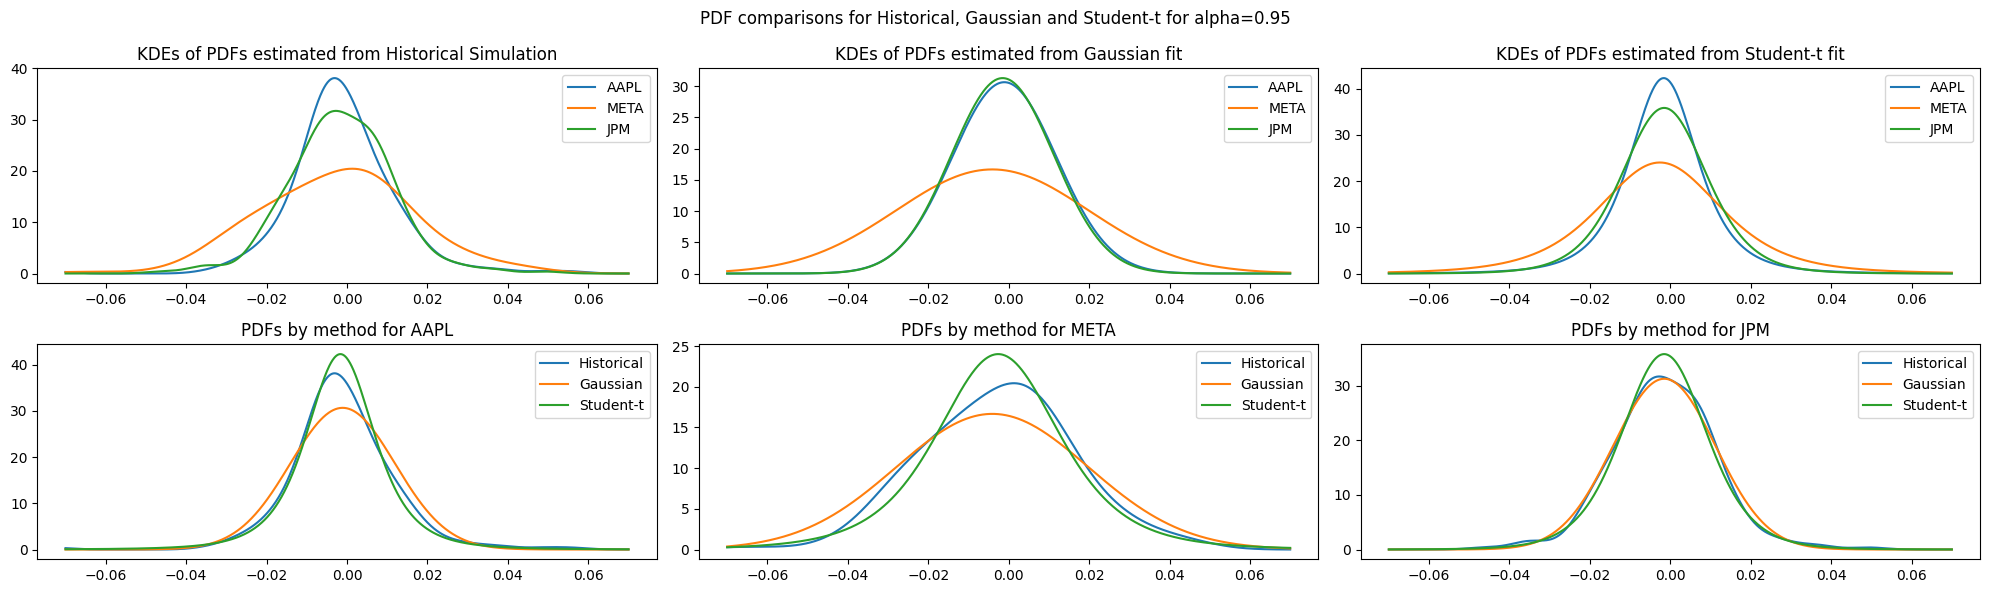

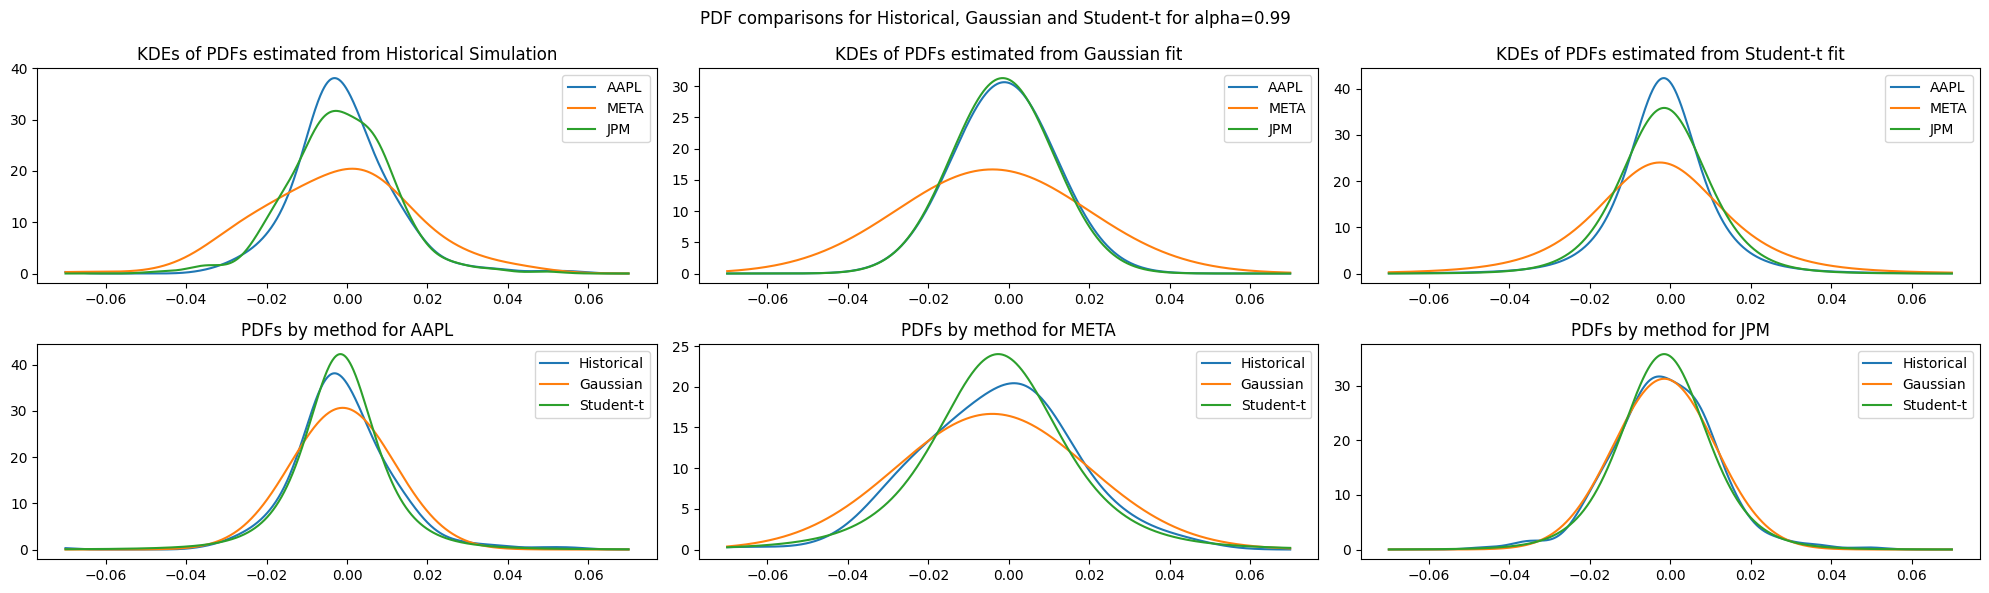

In [22]:
KDE_visualisations_hist_gauss_stud(alpha=0.95)

KDE_visualisations_hist_gauss_stud(alpha=0.99)

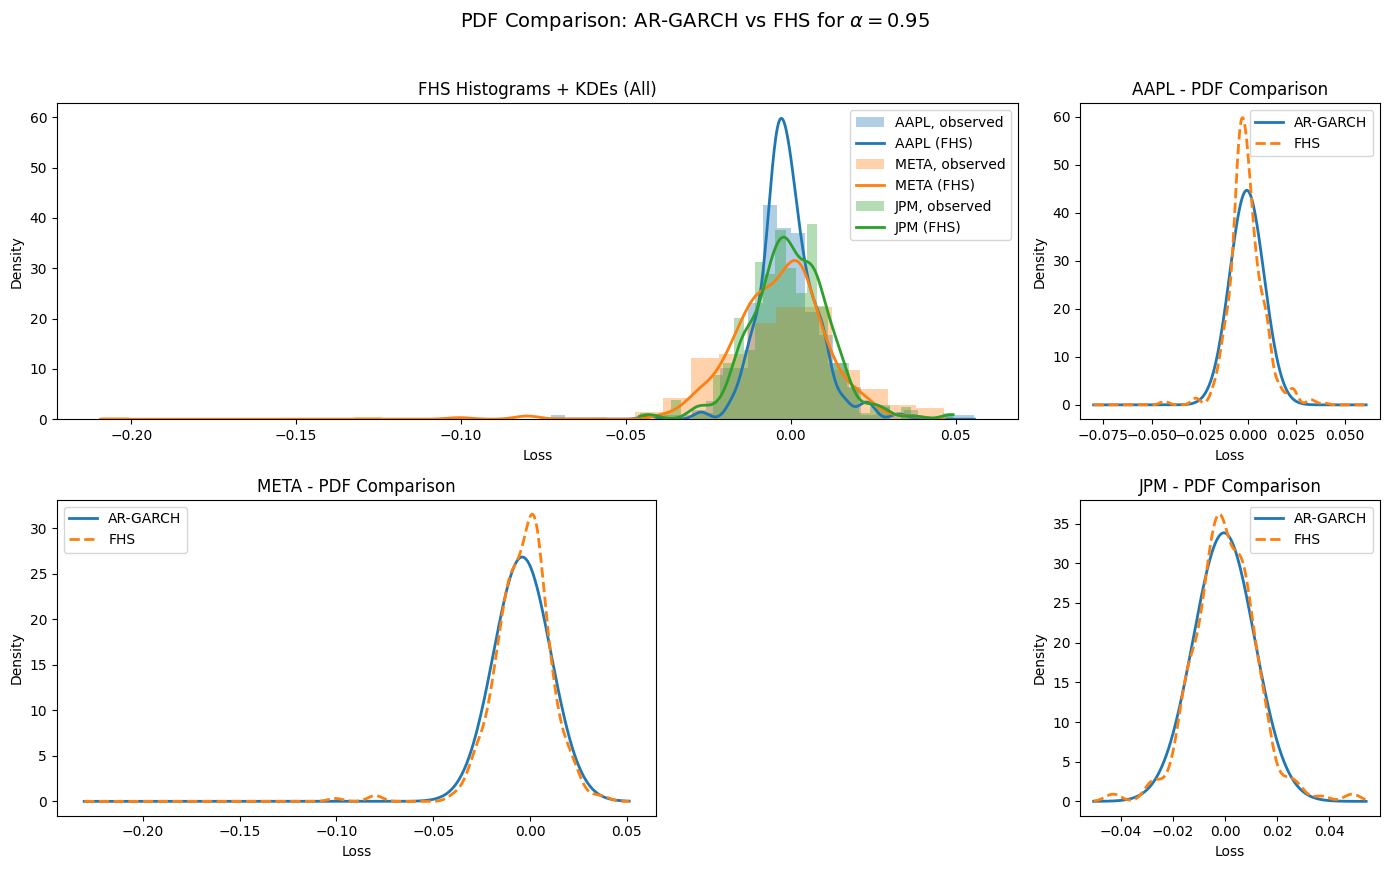

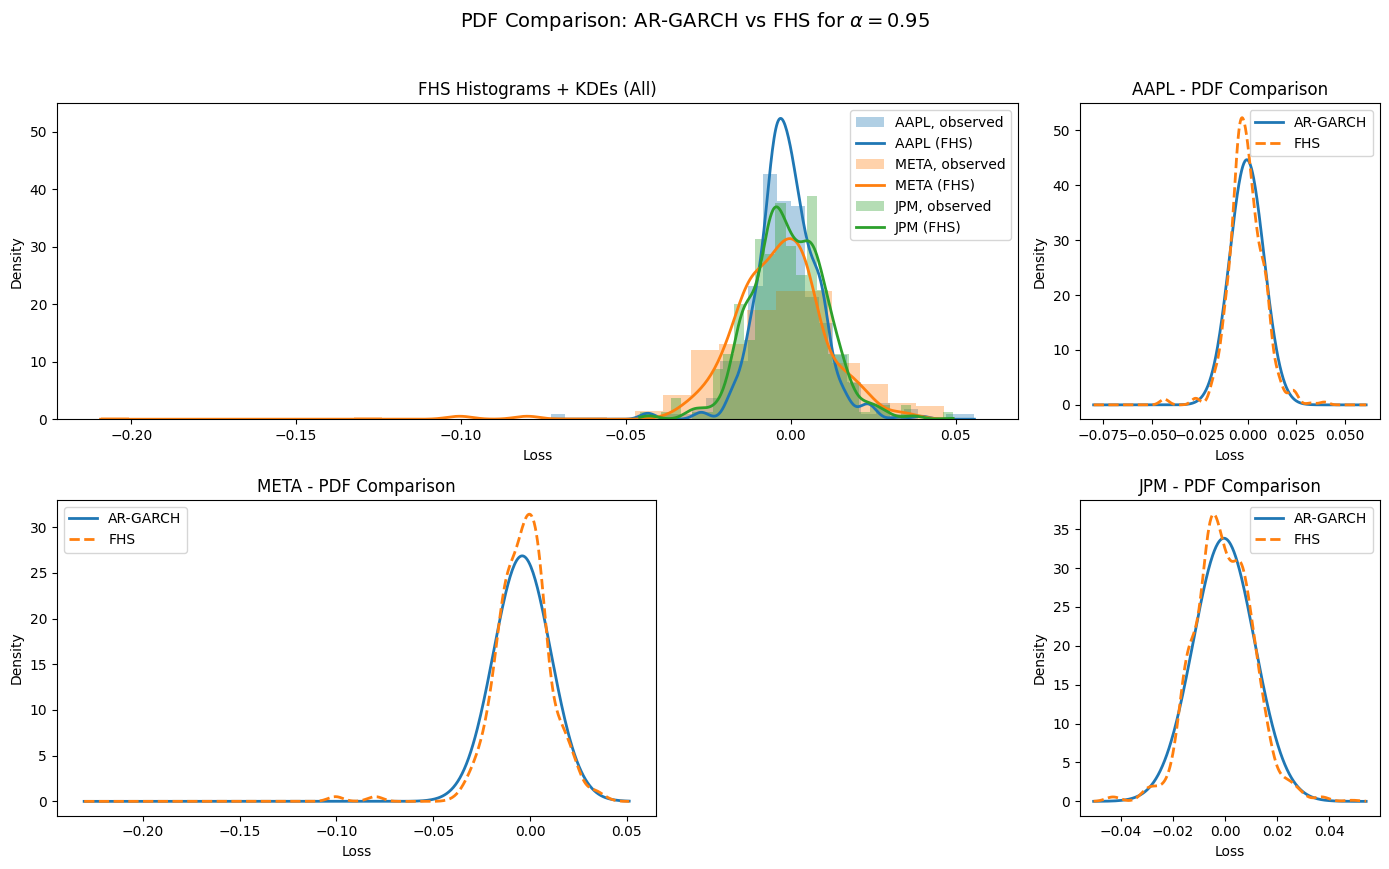

In [23]:
plot_pdfs_AR_GARCH_vs_FHS(
    losses_W=losses_W,
    p=(1,1,1),
    alpha=0.95,
    n_boot_samples=1000
)

plot_pdfs_AR_GARCH_vs_FHS(
    losses_W=losses_W,
    p=(1,1,1),
    alpha=0.95,
    n_boot_samples=1000
)

## **Part 3 - Backtesting Value at Risk and Expected Shortfall**

### Backtest functions

In [ ]:

def backtest_computations(
    losses: pd.DataFrame,
    methods: list,
    alphas: list[float]
) -> tuple[pd.DataFrame, dict[float, pd.DataFrame]]:
    """
    Rolling-window VaR/ES forecasts for several methods.

    Returns
    -------
    df : DataFrame
        Columns: MultiIndex (Alpha, Ticker, Method, Metric) with
        Metric in {"VaR", "ES"}.
    var_df : dict[float, DataFrame]
        For each alpha, a DataFrame with MultiIndex columns (Ticker, Method)
        containing only the VaR time series.
    """
    tickers = list(losses.columns)   # <--- use actual columns (this is really important! if removed the code breaks for backtesting portfolio)

    # results[alpha][ticker][method][metric] = list of forecasts
    results = {
        alpha: {
            ticker: {method: {"VaR": [], "ES": []} for method in methods}
            for ticker in tickers
        }
        for alpha in alphas
    }

    T = losses.shape[0]

    for t in range(W, T):
        window = losses.iloc[t - W: t]

        for alpha in alphas:
            res_historical, _ = var_es_historical(losses_W=window, alpha=alpha)
            res_gaussian,  _  = var_es_gaussian(losses_W=window, alpha=alpha)
            res_student,  _   = var_es_student_t(losses_W=window, alpha=alpha)
            res_garch,    _   = forecast_var_es_AR_GARCH(losses_W=window, alpha=alpha)
            res_fhs,      _   = forecast_var_es_fhs(losses_W=window, alpha=alpha, p=(7, 7, 5))

            for ticker in tickers:
                # Historical
                results[alpha][ticker]["historical"]["VaR"].append(res_historical[ticker]["VaR"])
                results[alpha][ticker]["historical"]["ES"].append(res_historical[ticker]["ES"])

                # Gaussian
                results[alpha][ticker]["gaussian"]["VaR"].append(res_gaussian[ticker]["VaR"])
                results[alpha][ticker]["gaussian"]["ES"].append(res_gaussian[ticker]["ES"])

                # Student t
                results[alpha][ticker]["student"]["VaR"].append(res_student[ticker]["VaR"])
                results[alpha][ticker]["student"]["ES"].append(res_student[ticker]["ES"])

                # GARCH
                results[alpha][ticker]["garch"]["VaR"].append(res_garch[ticker]["VaR"])
                results[alpha][ticker]["garch"]["ES"].append(res_garch[ticker]["ES"])

                # FHS
                results[alpha][ticker]["fhs"]["VaR"].append(res_fhs[ticker]["VaR"])
                results[alpha][ticker]["fhs"]["ES"].append(res_fhs[ticker]["ES"])

    # Out-of-sample dates
    dates_oos = losses.index[W:]

    # --- Build var_df: per alpha, a (Ticker, Method) VaR DataFrame ---
    var_df: dict[float, pd.DataFrame] = {}

    for alpha in alphas:
        data_var = {}
        for ticker in tickers:
            for method in methods:
                data_var[(ticker, method)] = results[alpha][ticker][method]["VaR"]

        var_df_alpha = pd.DataFrame(data_var, index=dates_oos)
        var_df_alpha.columns = pd.MultiIndex.from_tuples(
            var_df_alpha.columns, names=["Ticker", "Method"]
        )
        var_df[alpha] = var_df_alpha

    # --- Build a “long” df with (Alpha, Ticker, Method, Metric) ---
    data = {}
    for alpha in alphas:
        for ticker in tickers:
            for method in methods:
                for metric in ("VaR", "ES"):
                    key = (alpha, ticker, method, metric)
                    data[key] = results[alpha][ticker][method][metric]

    df = pd.DataFrame(data, index=dates_oos)
    df.columns = pd.MultiIndex.from_tuples(
        df.columns, names=["Alpha", "Ticker", "Method", "Metric"]
    )

    return df, var_df


In [25]:
def backtest_var_plot(losses: pd.DataFrame, var_df: dict, alpha_plot: float, methods: list) -> None:
    """
    Plot realized losses vs VaR forecasts.
    
    Parameters:
    - losses: DataFrame with shape (dates, tickers) containing realized losses
    - var_df: Nested dict with structure {alpha: {ticker: {method: {'VaR': [values]}}}}
    - alpha_plot: Confidence level to plot (e.g., 0.95, 0.99)
    - methods: List of VaR methods to plot
    """
    dates_oos = losses.index[W:]  # Assuming W is defined globally
    tickers = list(losses.columns)
    
    for ticker in tickers:
        plt.figure(figsize=(14, 5))
        
        # Realized losses
        plt.plot(dates_oos, losses[ticker].loc[dates_oos], label="Realized loss", linewidth=2)
        
        # VaR forecasts per method
        for method in methods:
            var_values = var_df[alpha_plot][ticker][method]
            plt.plot(
                dates_oos,
                var_values,
                label=f"VaR {int(alpha_plot*100)}% - {method}"
            )
        
        plt.title(f"{ticker} – VaR {int(alpha_plot*100)}% vs realized losses")
        plt.xlabel("Date")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

### Value at Risk backtest

In [26]:
methods = ["historical", "gaussian", "student", "garch", "fhs"]

df, var_df_095 = backtest_computations(losses=losses, methods=methods, alphas=[0.95])
df, var_df_099 = backtest_computations(losses=losses, methods=methods, alphas=[0.99])

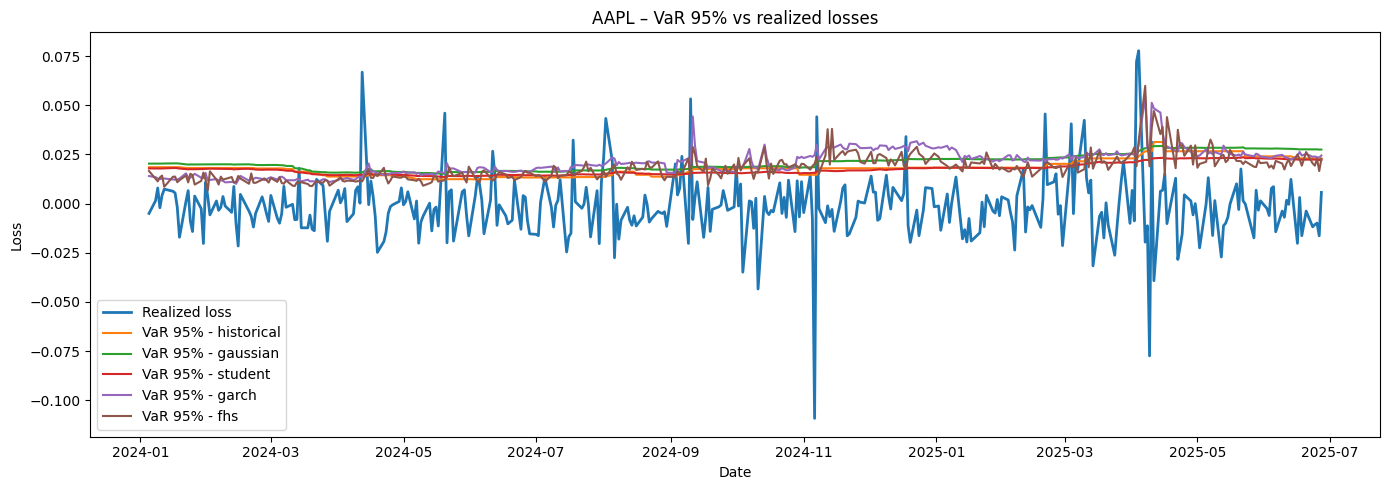

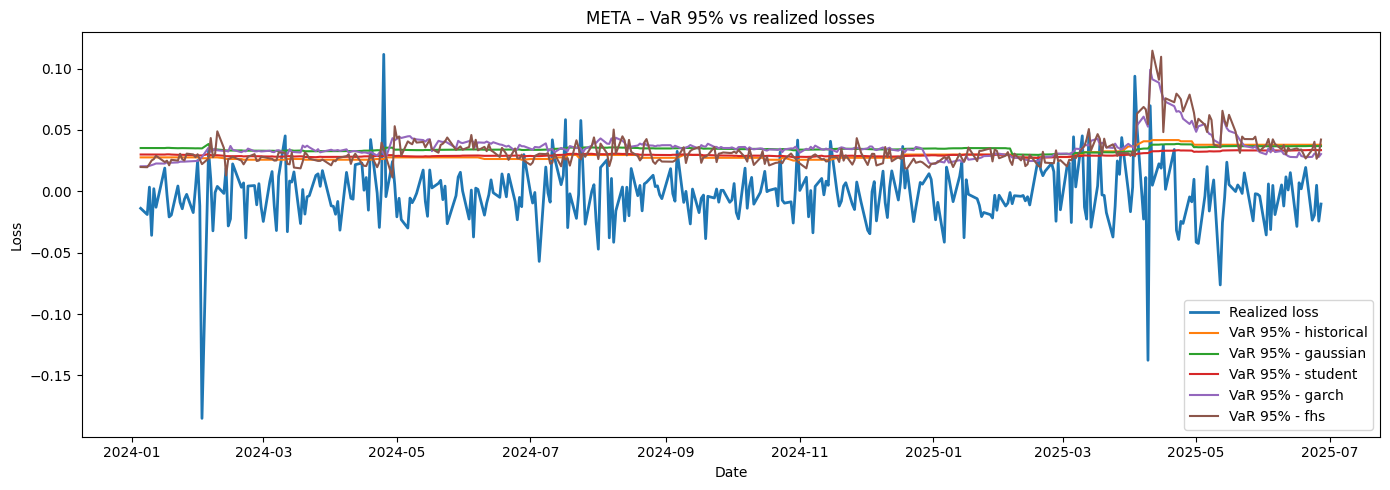

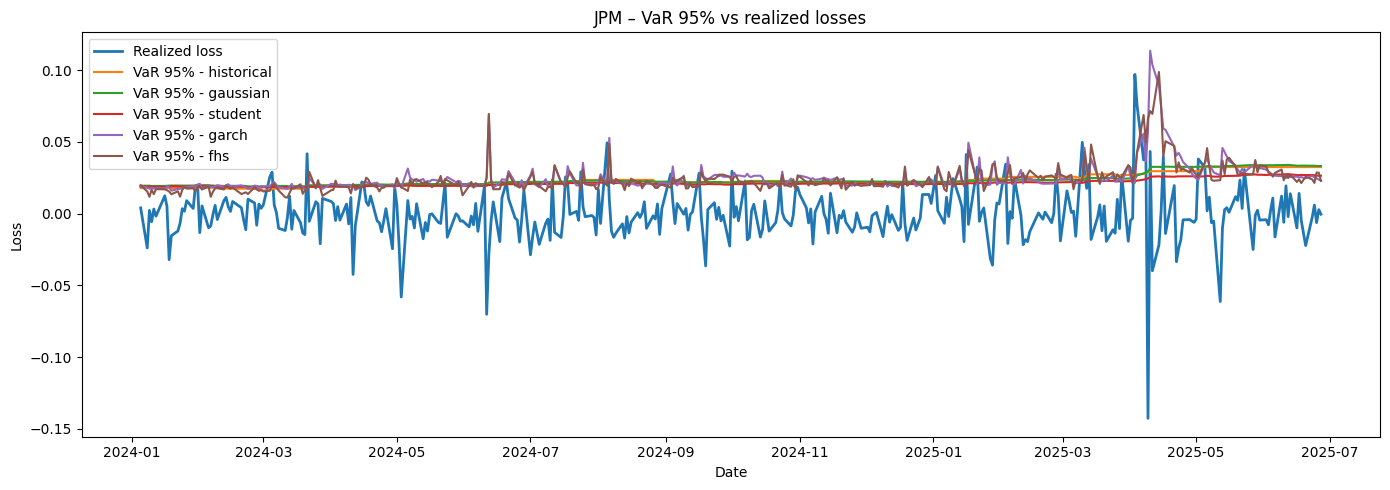

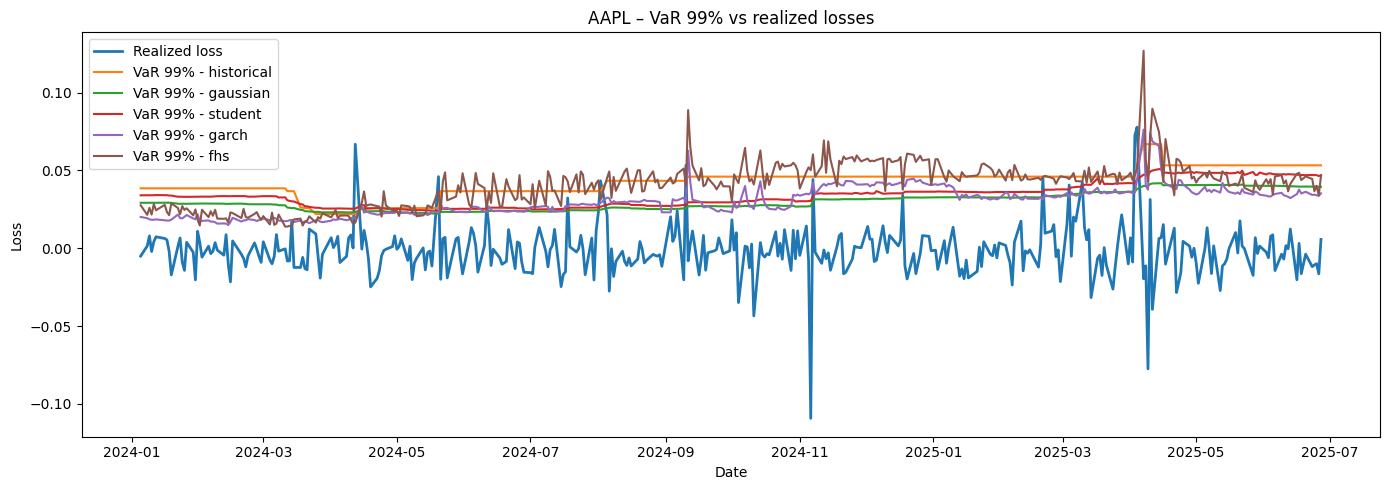

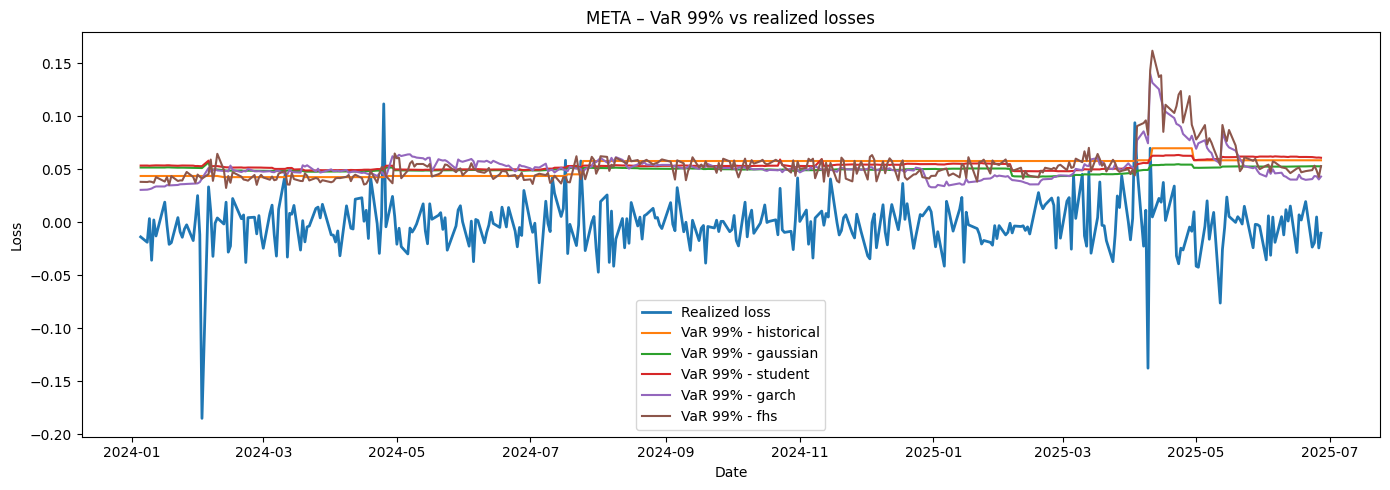

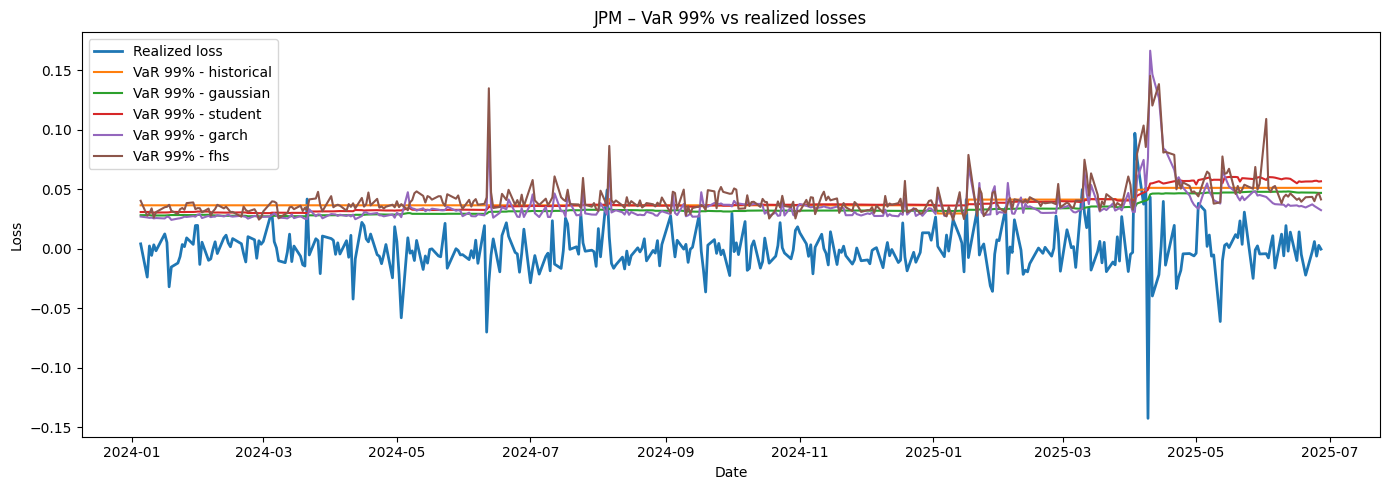

In [27]:
backtest_var_plot(losses=losses, var_df=var_df_095, alpha_plot=0.95, methods=methods)
print("="*80)
backtest_var_plot(losses=losses, var_df=var_df_099, alpha_plot=0.99, methods=methods)

#### Kupiec POF test

In [ ]:
def compute_exceptions(loss_series: pd.Series, var_series: pd.Series) -> pd.Series:
    """
    Both series should be aligned on the same index.
    Exception = 1 if loss_t > VaR_t (VaR is violated).
    """
    L, V = loss_series.align(var_series, join="inner")
    I = (L > V).astype(int)
    return I

def kupiec_pof_test(exceptions: pd.Series, alpha: float) -> Dict[str, float]:
    """
    Kupiec Proportion-of-Failures test (unconditional coverage).
    """
    p0 = 1 - alpha
    I = exceptions.values
    T = len(I)
    N = I.sum()
    
    if T == 0:
        raise ValueError("No observations for POF test.")
    
    p_hat = N / T
    
    # Guard against log(0)
    if p_hat in (0.0, 1.0):
        # Extreme case: LR becomes very large
        LR_pof = 2 * T
    else:
        logL0 = (T - N) * np.log(1 - p0) + N * np.log(p0)
        logL1 = (T - N) * np.log(1 - p_hat) + N * np.log(p_hat)
        LR_pof = -2 * (logL0 - logL1)
    
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    
    return {
        "N": int(N),
        "T": int(T),
        "hit_rate": p_hat,
        "LR_pof": LR_pof,
        "p_pof": p_value
    }

def christoffersen_ind_cc_tests(exceptions: pd.Series, lr_pof: float) -> Dict[str, float]:
    """
    Christoffersen independence and conditional coverage tests.
    """
    I = exceptions.values.astype(int)
    if len(I) < 2:
        raise ValueError("Need at least 2 observations for independence test.")
    
    I_prev = I[:-1]
    I_curr = I[1:]
    
    N00 = np.sum((I_prev == 0) & (I_curr == 0))
    N01 = np.sum((I_prev == 0) & (I_curr == 1))
    N10 = np.sum((I_prev == 1) & (I_curr == 0))
    N11 = np.sum((I_prev == 1) & (I_curr == 1))
    
    N0dot = N00 + N01
    N1dot = N10 + N11
    Ndot0 = N00 + N10
    Ndot1 = N01 + N11
    
    if N0dot == 0:
        pi0_hat = 0.0
    else:
        pi0_hat = N01 / N0dot
    
    if N1dot == 0:
        pi1_hat = 0.0
    else:
        pi1_hat = N11 / N1dot
    
    p_hat = (N01 + N11) / (N00 + N01 + N10 + N11)
    
    def safe_log(x):
        return np.log(np.clip(x, 1e-12, 1 - 1e-12))
    
    # Likelihood under Markov alternative (H1)
    logL1 = (
        N00 * safe_log(1 - pi0_hat) +
        N01 * safe_log(pi0_hat) +
        N10 * safe_log(1 - pi1_hat) +
        N11 * safe_log(pi1_hat)
    )
    
    # Likelihood under iid Bernoulli(p_hat) (H0)
    logL0 = (
        Ndot0 * safe_log(1 - p_hat) +
        Ndot1 * safe_log(p_hat)
    )
    
    LR_ind = -2 * (logL0 - logL1)
    p_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    LR_cc = lr_pof + LR_ind
    p_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    return {
        "N00": int(N00),
        "N01": int(N01),
        "N10": int(N10),
        "N11": int(N11),
        "LR_ind": LR_ind,
        "p_ind": p_ind,
        "LR_cc": LR_cc,
        "p_cc": p_cc
    }


In [29]:
def run_var_backtests(
    losses: pd.DataFrame,
    var_df: Dict[float, dict],
    alphas: list[float],
    methods: list[str]
) -> pd.DataFrame:
    """
    Run VaR backtests with Kupiec POF and Christoffersen tests.
    
    Parameters:
    - losses: DataFrame with shape (dates, tickers) containing realized losses
    - var_df: Nested dict with structure {alpha: {ticker: {method: {'VaR': [values]}}}}
    - alphas: List of confidence levels to test
    - methods: List of VaR methods to test
    """
    
    rows = []
    tickers = list(losses.columns)
    
    for alpha in alphas:
        var_dict = var_df[alpha]  # Get the dict for this alpha
        
        for ticker in tickers:
            for method in methods:
                # Extract VaR values for this combination
                var_values = var_dict[ticker][method]
                
                # Align losses with VaR forecast dates
                # Trim losses to match length of VaR values
                L = losses[ticker].iloc[-len(var_values):]
                V = pd.Series(var_values, index=L.index)
                
                # Exceptions (1 if loss exceeds VaR, 0 otherwise)
                I = compute_exceptions(L, V)
                
                # Kupiec POF test
                kup = kupiec_pof_test(I, alpha=alpha)
                
                # Christoffersen independence & conditional coverage tests
                ch = christoffersen_ind_cc_tests(I, lr_pof=kup["LR_pof"])
                
                row = {
                    "Ticker": ticker,
                    "Method": method,
                    "Alpha": alpha,
                    "N_exceptions": kup["N"],
                    "T": kup["T"],
                    "Hit_rate": kup["hit_rate"],
                    "LR_POF": kup["LR_pof"],
                    "p_POF": kup["p_pof"],
                    "LR_ind": ch["LR_ind"],
                    "p_ind": ch["p_ind"],
                    "LR_CC": ch["LR_cc"],
                    "p_CC": ch["p_cc"]
                }
                rows.append(row)
    
    return pd.DataFrame(rows)

def run_es_backtest(losses: pd.DataFrame, 
                    models: list[str], 
                    alphas: list[float], 
                    W: int = 252,
                    M: int = 1000):

    T = losses.shape[0]
    # print("T: ",T)
    # print("W:", W)
    # print("T-W+1: ", T-W+1)
    tickers = list(losses.columns)

    # Store VaR / ES / params
    res = {model: {str(alpha): {} for alpha in alphas} for model in models}

    # Store simulations: alpha -> model -> time -> {"L", "I"}
    simulations = {str(alpha): {model: {ticker: {} for ticker in tickers} for model in models} for alpha in alphas}

    Z_1 = {str(alpha): {model: {ticker: 0.0 for ticker in tickers} for model in models} for alpha in alphas}
    N = {str(alpha): {model: {ticker: 0 for ticker in tickers} for model in models} for alpha in alphas}

    for t in range(T - W + 1, T):
        print(t, end='\r')

        window_t = losses.iloc[t - W : t, :]

        for alpha in alphas:

            # --- Compute VaR/ES ---
            est_hist, par_hist = var_es_historical(losses_W=window_t, alpha=alpha)
            est_gauss, par_gauss = var_es_gaussian(losses_W=window_t, alpha=alpha)
            est_stud, par_stud = var_es_student_t(losses_W=window_t, alpha=alpha)
            est_garch, par_garch = forecast_var_es_AR_GARCH(losses_W=window_t, p=(7,7,5), alpha=alpha)
            est_fhs, par_fhs = forecast_var_es_fhs(losses_W=window_t, p=(7,7,5), n_boot_samples=M, alpha=alpha)

            model_results = {
                "historical": (est_hist, par_hist),
                "gaussian": (est_gauss, par_gauss),
                "student": (est_stud, par_stud),
                "garch": (est_garch, par_garch),
                "fhs": (est_fhs, par_fhs)
            }

            # --- Store VaR / ES / params ---
            for model_name, (est, par) in model_results.items():
                for ticker in tickers:
                    res[model_name][str(alpha)][ticker] = {
                        "VaR": est[ticker]["VaR"],
                        "ES": est[ticker]["ES"],
                        "params": par.get(ticker, par)
                    }

            # For now: run per ticker independently
            for ticker in tickers:

                VaR_hist = res["historical"][str(alpha)][ticker]["VaR"]
                VaR_gauss = res["gaussian"][str(alpha)][ticker]["VaR"]
                VaR_stud = res["student"][str(alpha)][ticker]["VaR"]
                VaR_garch = res["garch"][str(alpha)][ticker]["VaR"]
                VaR_fhs = res["fhs"][str(alpha)][ticker]["VaR"]

                # --- Historical simulation ---
                L_hist = np.random.choice(window_t[ticker], size=M, replace=True)
                I_hist = (L_hist > VaR_hist).astype(int)

                # --- Gaussian ---
                gauss_param = res["gaussian"][str(alpha)][ticker]["params"]
                L_gauss = norm.rvs(
                    loc=gauss_param.params["mu"],
                    scale=gauss_param.params["sigma"],
                    size=M
                )
                I_gauss = (L_gauss > VaR_gauss).astype(int)

                # --- Student t ---
                stud_param = res["student"][str(alpha)][ticker]["params"]
                L_stud = t_stud.rvs(
                    df=stud_param.params["nu"],
                    loc=stud_param.params["mu"],
                    scale=stud_param.params["sigma"],
                    size=M
                )
                I_stud = (L_stud > VaR_stud).astype(int)

                # --- GARCH ---
                garch_param = res["garch"][str(alpha)][ticker]["params"]
                L_garch = norm.rvs(
                    loc=garch_param.params["mu"],
                    scale=garch_param.params["sigma"],
                    size=M
                )
                print("mu_t: ", garch_param.params["mu"], " | sigma_t: ", garch_param.params["sigma"], end="\r")
                I_garch = (L_garch > VaR_garch).astype(int)

                # --- FHS ---
                fhs_param = res["fhs"][str(alpha)][ticker]["params"]
                L_fhs = fhs_param.params["values"][:M]
                I_fhs = (L_fhs > VaR_fhs).astype(int)

                # --- Store simulations ---
                simulations[str(alpha)]["historical"][ticker][t] = {"L": L_hist, "I": I_hist, "ES": res["historical"][str(alpha)][ticker]["ES"]}
                simulations[str(alpha)]["gaussian"][ticker][t] = {"L": L_gauss, "I": I_gauss, "ES": res["gaussian"][str(alpha)][ticker]["ES"]}
                simulations[str(alpha)]["student"][ticker][t] = {"L": L_stud, "I": I_stud, "ES": res["student"][str(alpha)][ticker]["ES"]}
                simulations[str(alpha)]["garch"][ticker][t] = {"L": L_garch, "I": I_garch, "ES": res["garch"][str(alpha)][ticker]["ES"]}
                simulations[str(alpha)]["fhs"][ticker][t] = {"L": L_fhs, "I": I_fhs, "ES": res["fhs"][str(alpha)][ticker]["ES"]}

                # Compute "benchmark" Z1
                for model in models:
                    I_t = int(losses[ticker].iloc[t] > res[model][str(alpha)][ticker]["VaR"])
                    L_t = losses[ticker].iloc[t]

                    Z_1[str(alpha)][model][ticker] += I_t * L_t / res[model][str(alpha)][ticker]["ES"]
                    N[str(alpha)][model][ticker]   += I_t


    N_m = {str(alpha): {model: {ticker: np.sum([simulations[str(alpha)][model][ticker][t]["I"] for t in range(T-W+1, T)], axis=0) for ticker in tickers} for model in models} for alpha in alphas}
    Z_1_m ={str(alpha): {model: {ticker: np.sum([simulations[str(alpha)][model][ticker][t]["I"] * simulations[str(alpha)][model][ticker][t]["L"] / simulations[str(alpha)][model][ticker][t]["ES"] for t in range(T-W+1, T)], axis=0) for ticker in tickers} for model in models} for alpha in alphas}
    
    for alpha in alphas:
        for model in models:
            for ticker in tickers:
                Z_1[str(alpha)][model][ticker] /= N[str(alpha)][model][ticker]
                # Z_1[str(alpha)][model][ticker] += -1

                for m in range(M):
                    Z_1_m[str(alpha)][model][ticker][m] = Z_1_m[str(alpha)][model][ticker][m] / N_m[str(alpha)][model][ticker][m] if N_m[str(alpha)][model][ticker][m] != 0 else -np.inf




    p = {str(alpha): {model: {ticker: {(1 / (M - np.sum(np.array([Z_1_m[str(alpha)][model][ticker] == -np.inf]).astype(int)))) * np.sum(np.array([Z_1_m[str(alpha)][model][ticker][m] >= Z_1[str(alpha)][model][ticker] for m in range(M)]).astype(int))} for ticker in tickers} for model in models} for alpha in alphas}
    
    # print("Nm: ", N_m)
    # print("Z_1_m: ", Z_1_m)

    # Compute "benchmark" Z1
    # print("Z_1: ", Z_1)
    # print("N: ", N)


    return p, N_m, Z_1_m, Z_1, simulations, res   

In [30]:
def plot_es_p_values(p: pd.DataFrame) -> None:
    rows = []
    for alpha, models in p.items():
        for model, tickers in models.items():
            for ticker_name, val_set in tickers.items():
                # val_set is a set with a single float
                value = list(val_set)[0]  # extract the float
                rows.append({'alpha': alpha, 'model': model, 'ticker': ticker_name, 'value': value})

    df = pd.DataFrame(rows)

    # Pivot for plotting
    pivot_df = df.pivot_table(index='ticker', columns=['alpha', 'model'], values='value')

    # Plot as grouped bar chart
    pivot_df.plot(kind='bar', figsize=(10,6))
    plt.ylabel('Value')
    plt.title('p values by Model and Ticker')
    plt.xticks(rotation=0)
    plt.legend(title='Alpha, Model', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [31]:
var_backtests_095 = run_var_backtests(losses, var_df_095, alphas=[0.95], methods=methods)
var_backtests_095.sort_values(["Ticker", "Alpha", "Method"])

Ticker      Method  Alpha  N_exceptions    T  Hit_rate     LR_POF  \
4    AAPL         fhs   0.95            27  370  0.072973   3.622796   
3    AAPL       garch   0.95            19  370  0.051351   0.014105   
1    AAPL    gaussian   0.95            19  370  0.051351   0.014105   
0    AAPL  historical   0.95            23  370  0.062162   1.073138   
2    AAPL     student   0.95            23  370  0.062162   1.073138   
14    JPM         fhs   0.95            34  370  0.091892  11.077879   
13    JPM       garch   0.95            30  370  0.081081   6.386015   
11    JPM    gaussian   0.95            31  370  0.083784   7.455310   
10    JPM  historical   0.95            33  370  0.089189   9.803180   
12    JPM     student   0.95            40  370  0.108108  20.031440   
9    META         fhs   0.95            21  370  0.056757   0.341395   
8    META       garch   0.95            16  370  0.043243   0.371915   
6    META    gaussian   0.95            17  370  0.045946   0.131441   
5    META  historical   0.95            22  370  0.059459   0.658923   
7    META     student   0.95            24  370  0.064865   1.580101   

       p_POF    LR_ind     p_ind      LR_CC      p_CC  
4   0.056993  4.028006  0.044751   7.650802  0.021810  
3   0.905462  0.938139  0.332757   0.952244  0.621188  
1   0.905462  3.163680  0.075293   3.177785  0.204152  
0   0.300238  3.732860  0.053352   4.805998  0.090446  
2   0.300238  3.732860  0.053352   4.805998  0.090446  
14  0.000874  0.006909  0.933757  11.084788  0.003917  
13  0.011502  0.098777  0.753302   6.484792  0.039070  
11  0.006325  2.165868  0.141105   9.621177  0.008143  
10  0.001742  3.087930  0.078875  12.891111  0.001588  
12  0.000008  3.297361  0.069391  23.328802  0.000009  
9   0.559025  2.536023  0.111275   2.877418  0.237234  
8   0.541962  1.450922  0.228380   1.822837  0.401954  
6   0.716943  0.061098  0.804768   0.192539  0.908219  
5   0.416941  0.090370  0.763707   0.749293  0.687532  
7   0.208746  0.260123  0.610035   1.840224  0.398474

In [32]:
var_backtests_099 = run_var_backtests(losses, var_df_099, alphas=[0.99], methods=methods)
var_backtests_099.sort_values(["Ticker", "Alpha", "Method"])

Ticker      Method  Alpha  N_exceptions    T  Hit_rate     LR_POF  \
4    AAPL         fhs   0.99             8  370  0.021622   3.788416   
3    AAPL       garch   0.99            12  370  0.032432  11.827279   
1    AAPL    gaussian   0.99            13  370  0.035135  14.310172   
0    AAPL  historical   0.99             6  370  0.016216   1.215592   
2    AAPL     student   0.99            12  370  0.032432  11.827279   
14    JPM         fhs   0.99             8  370  0.021622   3.788416   
13    JPM       garch   0.99            13  370  0.035135  14.310172   
11    JPM    gaussian   0.99             9  370  0.024324   5.477110   
10    JPM  historical   0.99             7  370  0.018919   2.355902   
12    JPM     student   0.99             7  370  0.018919   2.355902   
9    META         fhs   0.99             5  370  0.013514   0.415670   
8    META       garch   0.99             4  370  0.010811   0.023938   
6    META    gaussian   0.99             9  370  0.024324   5.477110   
5    META  historical   0.99             6  370  0.016216   1.215592   
7    META     student   0.99             5  370  0.013514   0.415670   

       p_POF    LR_ind     p_ind      LR_CC      p_CC  
4   0.051608  2.033721  0.153844   5.822137  0.054418  
3   0.000584  0.728732  0.393294  12.556011  0.001877  
1   0.000155  0.526175  0.468219  14.836347  0.000600  
0   0.270227  3.143157  0.076246   4.358749  0.113112  
2   0.000584  0.728732  0.393294  12.556011  0.001877  
14  0.051608  0.354600  0.551521   4.143016  0.125996  
13  0.000155  0.526175  0.468219  14.836347  0.000600  
11  0.019267  1.616510  0.203579   7.093620  0.028816  
10  0.124810  2.534528  0.111380   4.890430  0.086707  
12  0.124810  2.534528  0.111380   4.890430  0.086707  
9   0.519106  0.137367  0.710913   0.553037  0.758420  
8   0.877043  0.087673  0.767157   0.111611  0.945723  
6   0.019267  1.616510  0.203579   7.093620  0.028816  
5   0.270227  0.198356  0.656051   1.413948  0.493134  
7   0.519106  0.137367  0.710913   0.553037  0.758420

### Expected Shortfall backtest

In [33]:
p, _, _, _, _, _ = run_es_backtest(losses, alphas=[0.95, 0.99], models=["historical", "gaussian", "student", "garch", "fhs"])

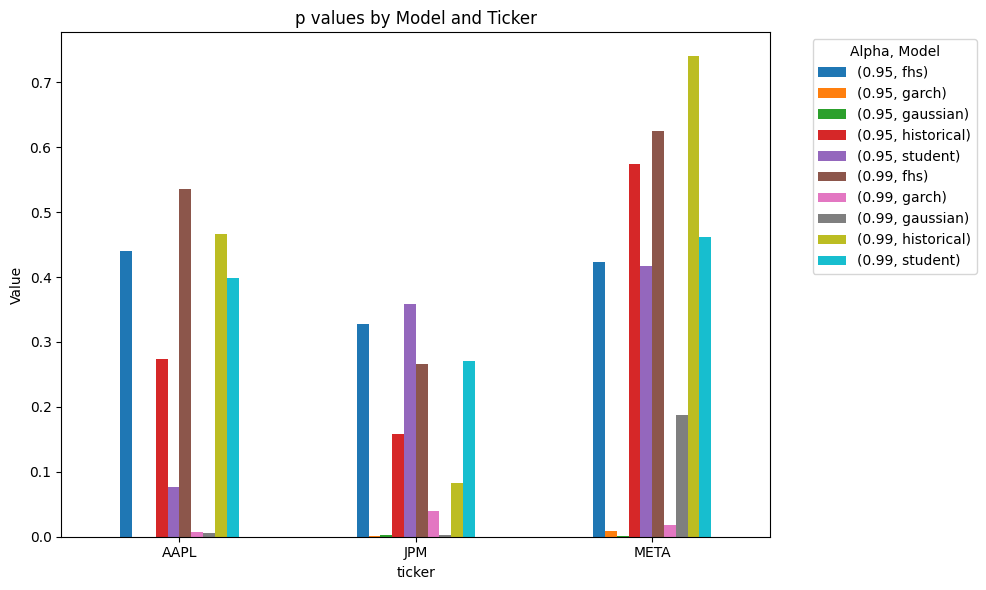

In [34]:
plot_es_p_values(p=p)

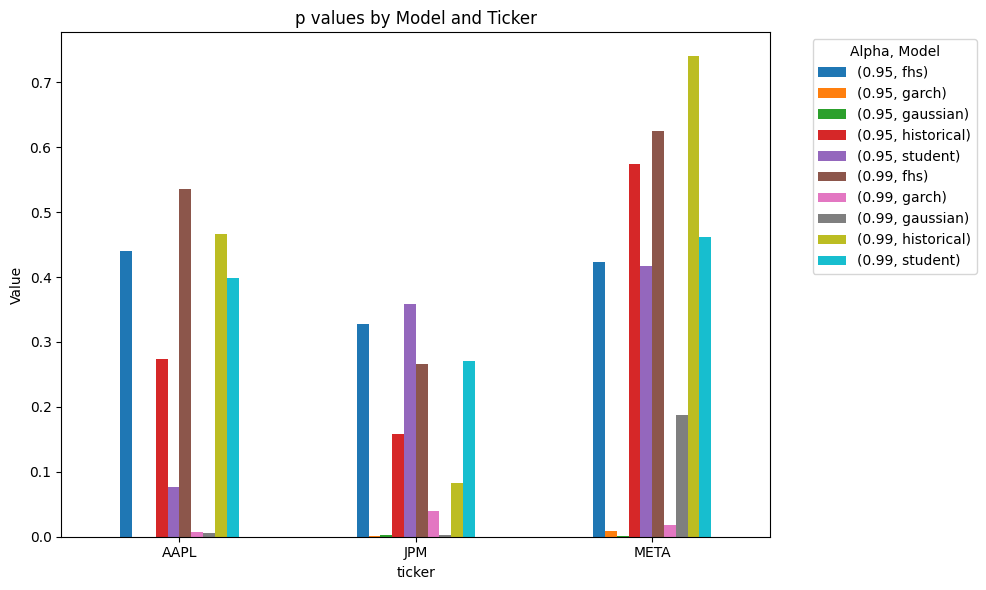

In [35]:
rows = []
for alpha, models in p.items():
    for model, tickers in models.items():
        for ticker_name, val_set in tickers.items():
            # val_set is a set with a single float
            value = list(val_set)[0]  # extract the float
            rows.append({'alpha': alpha, 'model': model, 'ticker': ticker_name, 'value': value})

df = pd.DataFrame(rows)

# Pivot for plotting
pivot_df = df.pivot_table(index='ticker', columns=['alpha', 'model'], values='value')

# Plot as grouped bar chart
pivot_df.plot(kind='bar', figsize=(10,6))
plt.ylabel('Value')
plt.title('p values by Model and Ticker')
plt.xticks(rotation=0)
plt.legend(title='Alpha, Model', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

### Performance ranking

In [36]:
def ranking_old(p_es: pd.DataFrame, var_099: pd.DataFrame, var_095: pd.DataFrame, models: list=["historical", "garch", "student", "gaussian", "fhs"], alphas: list=[0.95, 0.99], tickers=["AAPL", "META", "JPM"]) -> None:
    # es_p_averages = ["alpha": {np.sum(p_es["alpha"], axis=0) for alpha in ["0.95", "0.99"]}]
    avg = {str(alpha): {model: {ticker: 0.0 for ticker in tickers} for model in models} for alpha in alphas}
    for alpha in alphas: 
        for model in models:
            for ticker in tickers:
                if alpha == 0.95:

                    val_p_POF = var_095.loc[
                            (var_095["Ticker"] == "AAPL") &
                            (var_095["Alpha"] == 0.95) &
                            (var_095["Method"] == "garch"),
                            "p_POF"
                        ].iloc[0]
                    val_p_CC = var_095.loc[
                            (var_095["Ticker"] == "AAPL") &
                            (var_095["Alpha"] == 0.95) &
                            (var_095["Method"] == "garch"),
                            "p_CC"
                        ].iloc[0]
                    avg[str(alpha)][model][ticker] = (p_es[str(alpha)][model][ticker] + val_p_POF + val_p_CC) / 3

                elif alpha == 0.99:
                    val_p_POF = var_099.loc[
                            (var_099["Ticker"] == "AAPL") &
                            (var_099["Alpha"] == 0.99) &
                            (var_099["Method"] == "garch"),
                            "p_POF"
                        ].iloc[0]
                    val_p_CC = var_099.loc[
                            (var_099["Ticker"] == "AAPL") &
                            (var_099["Alpha"] == 0.99) &
                            (var_099["Method"] == "garch"),
                            "p_CC"
                        ].iloc[0]
                    avg[str(alpha)][model][ticker] = (p_es[str(alpha)][model][ticker] + val_p_POF + val_p_CC) / 3

    return avg

In [37]:
def ranking(p_es, var_099, var_095, 
            models=["historical", "garch", "student", "gaussian", "fhs"], 
            alphas=[0.95, 0.99], 
            tickers=["AAPL", "META", "JPM"]):

    avg = {
        str(alpha): {
            model: {ticker: 0.0 for ticker in tickers}
            for model in models
        }
        for alpha in alphas
    }

    for alpha in alphas:
        for model in models:
            for ticker in tickers:

                # extract float from set
                p_es_val = next(iter(p_es[str(alpha)][model][ticker]))

                if alpha == 0.95:
                    df = var_095
                else:
                    df = var_099

                val_p_POF = df.loc[
                    (df["Ticker"] == ticker) &
                    (df["Alpha"] == alpha) &
                    (df["Method"] == model),
                    "p_POF"
                ].iloc[0]

                val_p_CC = df.loc[
                    (df["Ticker"] == ticker) &
                    (df["Alpha"] == alpha) &
                    (df["Method"] == model),
                    "p_CC"
                ].iloc[0]

                avg[str(alpha)][model][ticker] = (
                    p_es_val + val_p_POF + val_p_CC
                ) / 3

    return avg


In [38]:
r=ranking(p_es=p, var_095=var_backtests_095, var_099=var_backtests_099)
r

{'0.95': {'historical': {'AAPL': np.float64(0.22156134799801683),
   'META': np.float64(0.5594909568400769),
   'JPM': np.float64(0.05377655524399874)},
  'garch': {'AAPL': np.float64(0.5088832542784668),
   'META': np.float64(0.3176387378332693),
   'JPM': np.float64(0.01719081905084004)},
  'student': {'AAPL': np.float64(0.15589468133135015),
   'META': np.float64(0.3414068478372207),
   'JPM': np.float64(0.1193387374402084)},
  'gaussian': {'AAPL': np.float64(0.3698712255802836),
   'META': np.float64(0.5420539561285271),
   'JPM': np.float64(0.005489341162433936)},
  'fhs': {'AAPL': np.float64(0.1729342338025127),
   'META': np.float64(0.4064196640781672),
   'JPM': np.float64(0.11093025798283808)}},
 '0.99': {'historical': {'AAPL': np.float64(0.282972449908341),
   'META': np.float64(0.5011205560174135),
   'JPM': np.float64(0.09818738129803556)},
  'garch': {'AAPL': np.float64(0.003008461645271757),
   'META': np.float64(0.613768084060004),
   'JPM': np.float64(0.0133236518551952

## **Part 4 - Copula fitting**

### Copula functions

In [39]:

def compute_U_t_i(losses_W: pd.DataFrame) -> pd.DataFrame:
    """
    Convert losses to uniform marginals using empirical CDF.
    
    Args:
        losses_W: DataFrame of losses with shape (W, n_assets)
        
    Returns:
        DataFrame of uniform marginals U_t_i in [0,1]
    """
    returns = -losses_W
    
    W = returns.shape[0]
    ranks = np.argsort(np.argsort(returns, axis=0), axis=0) + 1
    U_t_i = ranks / (W + 1)
    U_t_i = pd.DataFrame(U_t_i, columns=losses_W.columns, index=losses_W.index)
    return U_t_i, ranks

def fit_copula(U_data: pd.DataFrame, copula_type: str = "Gaussian"):
    """
    Fit a copula to uniform marginal data.
    
    Args:
        U_data: DataFrame of uniform marginals in [0,1]
        copula_type: Type of copula - "Gaussian", "Archimedean", or "Student"
        
    Returns:
        Tuple of (fitted copula object, parameters)
    """
    
    #if U_data.empty:
    #    raise ValueError("U_data cannot be empty")
    
    u = U_data.to_numpy()
    
    if copula_type == "Gaussian":
        copula = copulae.elliptical.GaussianCopula(dim=U_data.shape[1])
    elif copula_type == "Archimedean":
        from copulae.archimedean import ClaytonCopula
        copula = ClaytonCopula(dim=U_data.shape[1])
    elif copula_type == "Student":
        copula = copulae.elliptical.StudentCopula(dim=U_data.shape[1])
    else:
        raise ValueError(f"Unknown copula type: {copula_type}. Choose from 'Gaussian', 'Archimedean', or 'Student'")
    
 
    copula.fit(u)
    params = copula.params
    
    return copula, params

def generate_from_copula(U_data: pd.DataFrame, copula, number_of_samples: int = 1000) -> pd.DataFrame:
    """
    Generate random samples from a fitted copula.
    
    Args:
        U_data: Original DataFrame (used to get column names)
        copula: Fitted copula object
        number_of_samples: Number of samples to generate
        
    Returns:
        DataFrame of generated uniform samples with shape (number_of_samples, n_assets)
    """
    columns = U_data.columns
    samples = copula.random(number_of_samples)
    return pd.DataFrame(samples, columns=columns)

def inverse_transform(U_samples: pd.DataFrame, losses_W: pd.DataFrame) -> pd.DataFrame:
    """
    Convert uniform copula samples back to returns using the empirical distribution
    of the original losses (or returns).
    
    Args:
        U_samples: DataFrame of uniform samples from copula in [0,1]
        portfolio_losses: Original DataFrame of losses used to build empirical distribution
        
    Returns:
        DataFrame of recovered returns/losses with same columns as U_samples
    """
    returns_W = -losses_W
    recovered = pd.DataFrame(index=U_samples.index, columns=U_samples.columns)
    
    for col in U_samples.columns:
        sorted_vals = np.sort(returns_W[col].values)
        W = len(sorted_vals)
        
        # Map U to empirical quantile with linear interpolation
        # U=0 maps to smallest value, U=1 maps to largest value
        idx = U_samples[col].values * (W - 1)
        idx_lower = np.floor(idx).astype(int).clip(0, W - 1)
        idx_upper = np.minimum(idx_lower + 1, W - 1)
        weight = idx - idx_lower
        
        # Linear interpolation between adjacent empirical quantiles
        recovered[col] = (
            sorted_vals[idx_lower] * (1 - weight) + 
            sorted_vals[idx_upper] * weight
        )
    
    return recovered

def plot_observed_copulas_results(losses_W: pd.DataFrame) -> None:
    U, _ = compute_U_t_i(losses_W)

    R = pd.DataFrame(-losses_W, columns=losses_W.columns)
    combinations = [("AAPL", "META"), ("AAPL", "JPM"), ("JPM", "META")]

    fig, ax = plt.subplots(3, 2, figsize=(20, 9))

    for (idx, comb) in enumerate(combinations):
        ticker1, ticker2 = comb
        ax[idx, 0].scatter(U[ticker1], U[ticker2], label=f"U[{ticker1}] vs U[{ticker2}]")
        ax[idx, 1].scatter(R[ticker1], R[ticker2], label=f"R[{ticker1}] vs R[{ticker2}]")
        ax[idx, 0].legend()
        ax[idx, 1].legend()

def plot_simulated_copulas_results() -> None: 
    U, _ = compute_U_t_i(losses_W)
    cop_gaussian, par = fit_copula(U, "Gaussian")
    samples_gaussian = generate_from_copula(U, cop_gaussian, 252)

    cop_student, par = fit_copula(U, "Student")
    samples_student = generate_from_copula(U, cop_gaussian, 252)


    R_gaussian = inverse_transform(samples_gaussian, losses_W)
    R_student = inverse_transform(samples_student, losses_W)

    U_gaussian, _= compute_U_t_i(samples_gaussian)
    U_student, _ = compute_U_t_i(samples_student)

    combinations = [("AAPL", "META"), ("AAPL", "JPM"), ("JPM", "META")]
    R = pd.DataFrame(-losses_W, columns=losses_W.columns)

    fig, ax = plt.subplots(3, 2, figsize=(20, 9))
    for (idx, comb) in enumerate(combinations):
        ticker1, ticker2 = comb
        ax[idx, 0].scatter(U_gaussian[ticker1], U_gaussian[ticker2], 
                        label=f"U[{ticker1}] vs U[{ticker2}] (Gaussian - generated)", 
                        marker='o',
                        facecolors='none',
                        edgecolors='red')
        ax[idx, 1].scatter(R_gaussian[ticker1], R_gaussian[ticker2], 
                        label=f"R[{ticker1}] vs R[{ticker2}] (Gaussian - generated)", 
                        marker='o',
                        facecolors='none',
                        edgecolors='green')
        ax[idx, 0].scatter(U_student[ticker1], U_student[ticker2], 
                        label=f"U[{ticker1}] vs U[{ticker2}] (Student - generated)", 
                        marker='o',
                        facecolors='none',
                        edgecolors='purple')
        ax[idx, 1].scatter(R_student[ticker1], R_student[ticker2], 
                        label=f"R[{ticker1}] vs R[{ticker2}] (Student - generated)", 
                        marker='o',
                        facecolors='none',
                        edgecolors='orange')
        ax[idx, 1].scatter(-losses_W[ticker1], -losses_W[ticker2], label=f"R[{ticker1}] vs R[{ticker2}] (Observed)",
                        marker='+')

        ax[idx, 0].set_title(r"$(U_{t,i}, U_{t, j})_t$" + f" for i={ticker1} & j={ticker2}")
        ax[idx, 1].set_title(r"$(R_{t,i}, R_{t, j})_t$" + f" for i={ticker1} & j={ticker2}")
        ax[idx, 0].legend()
        ax[idx, 1].legend()
    fig.suptitle("Scatter plots, simulated and observed")
    fig.tight_layout()

    fig, ax = plt.subplots(3, 1, figsize=(20,9))
    x = np.arange(R.shape[0])
    for (idx, ticker) in enumerate(R.columns):
        ax[idx].plot(x, R_gaussian[ticker], 
                    label=f"Simulated returns - {ticker} (Gaussian)")
        ax[idx].plot(x, R_student[ticker], 
                    label=f"Simulated returns - {ticker} (Student)")
        ax[idx].plot(x, R[ticker], 
                    label=f"Observed returns - {ticker}")
        
        ax[idx].set_title(f"Returns - {ticker}")
        ax[idx].legend()
    fig.suptitle("Returns, simulated and observed")
    fig.tight_layout()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    for (idx, ticker) in enumerate(R.columns):
        ax[idx].hist(R_gaussian[ticker], 
                    label=f"Simulated returns - {ticker} (Gaussian)",
                    density=True,
                    bins='scott',
                    alpha=0.5)
        ax[idx].hist(R_student[ticker], 
                    label=f"Simulated returns - {ticker} (Student)",
                    density=True,
                    bins='scott',
                    alpha=0.5)
        ax[idx].hist(R[ticker], 
                    label=f"Observed returns - {ticker}",
                    density=True,
                    bins='scott',
                    alpha=0.5)
        
        ax[idx].set_title(f"Histograms of returns - {ticker}")
        ax[idx].legend()
    fig.suptitle("Histograms of returns, observed and simulated")
    fig.tight_layout()

### Observed data

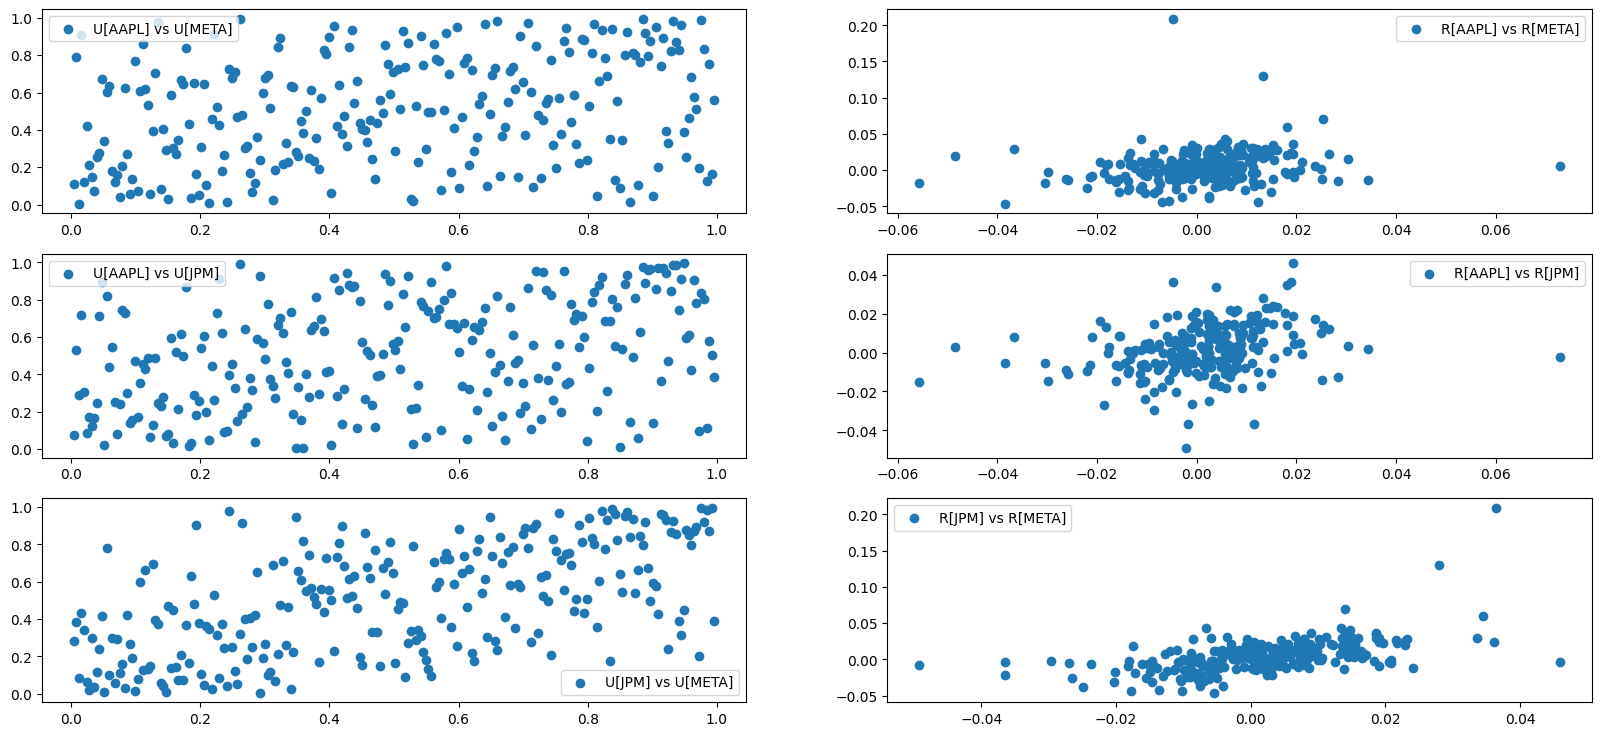

In [40]:
plot_observed_copulas_results(losses_W)

### Gaussian and Student simulated copulas

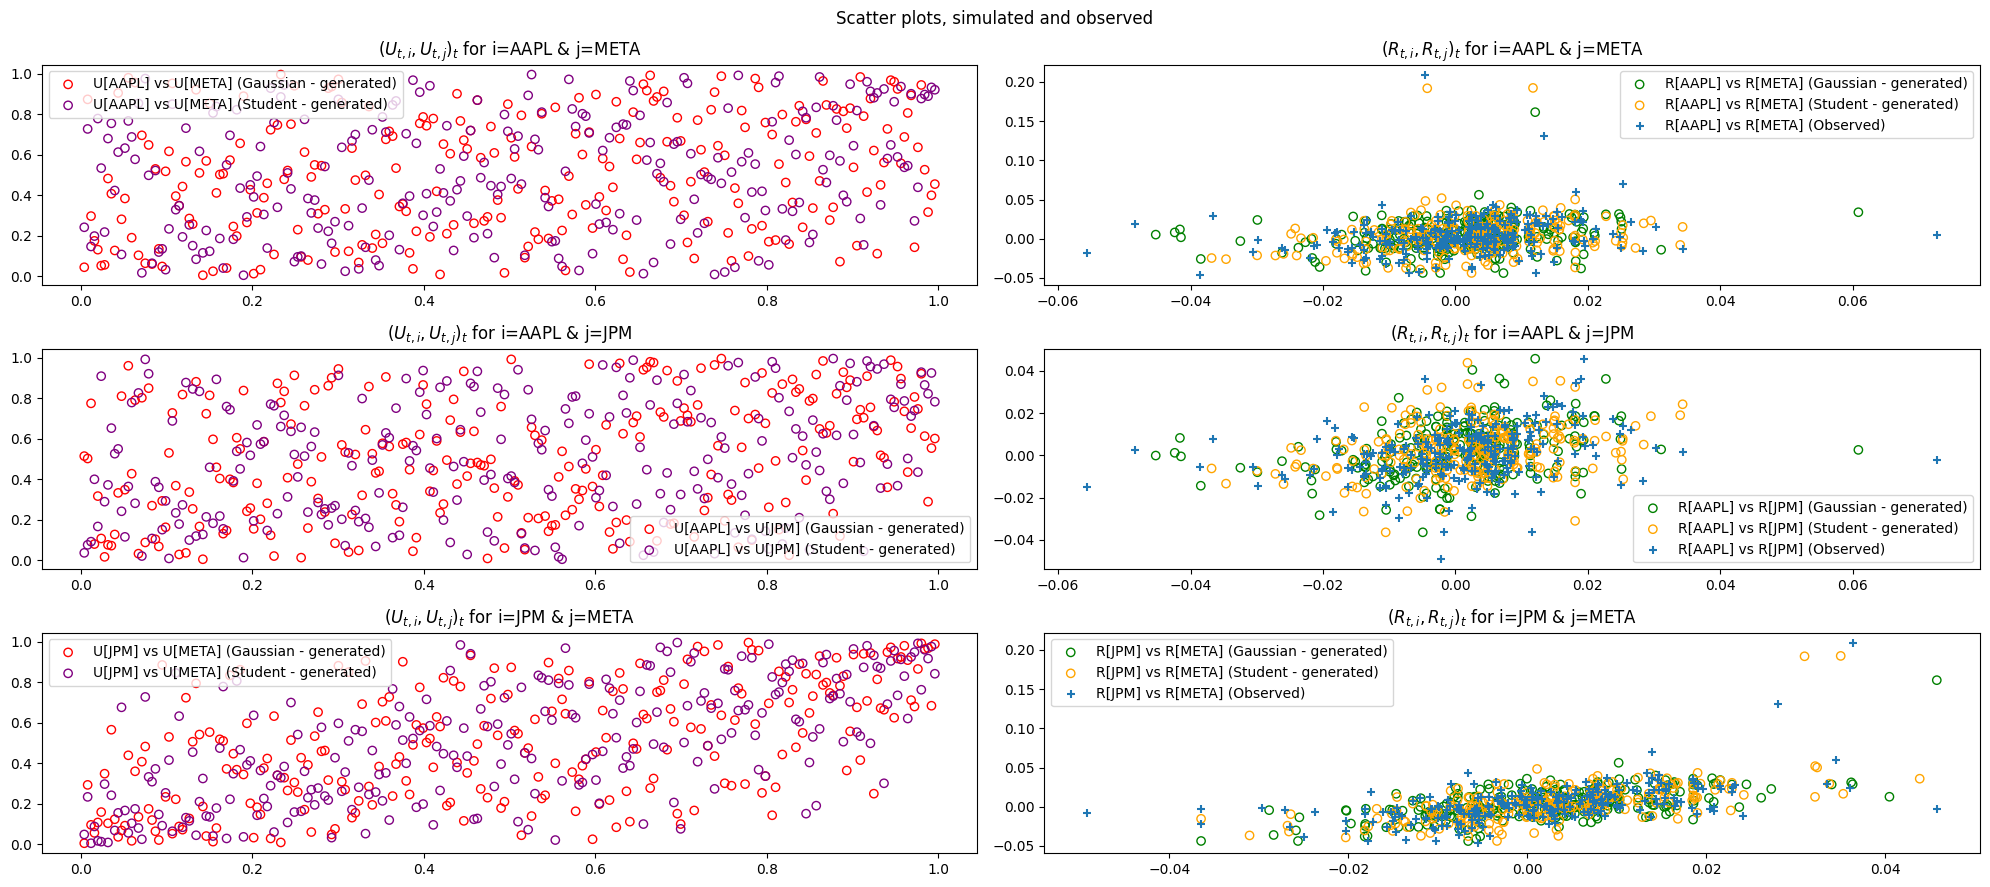

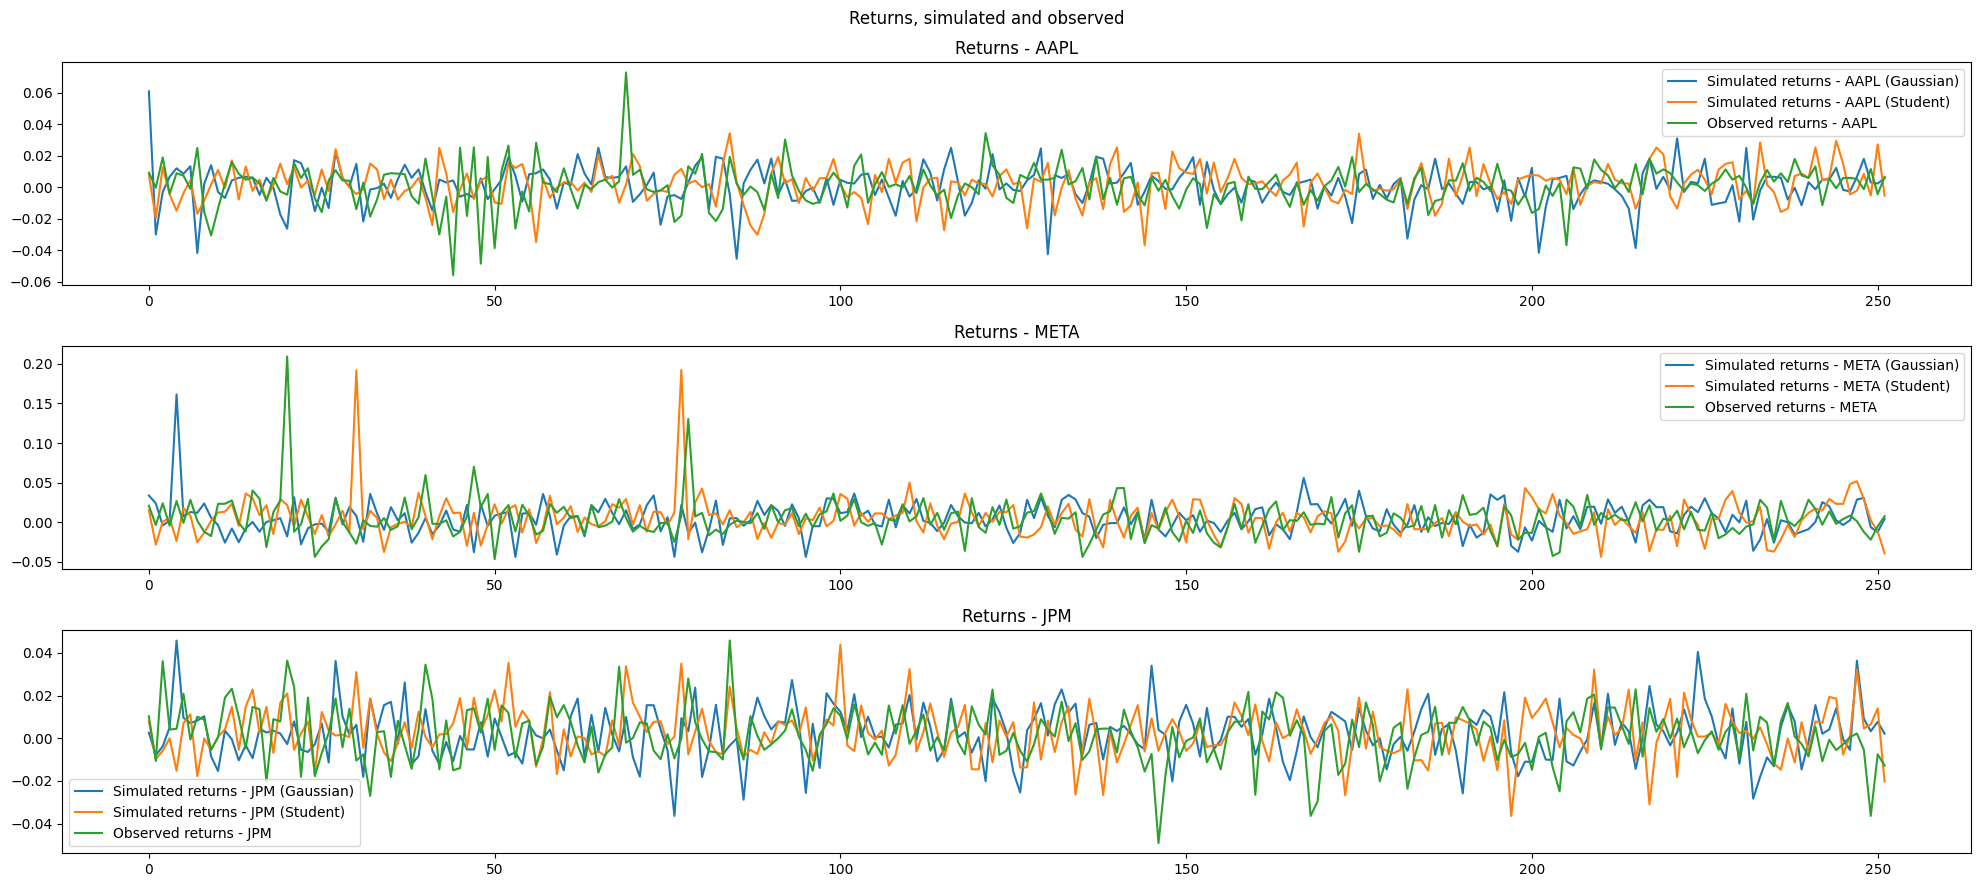

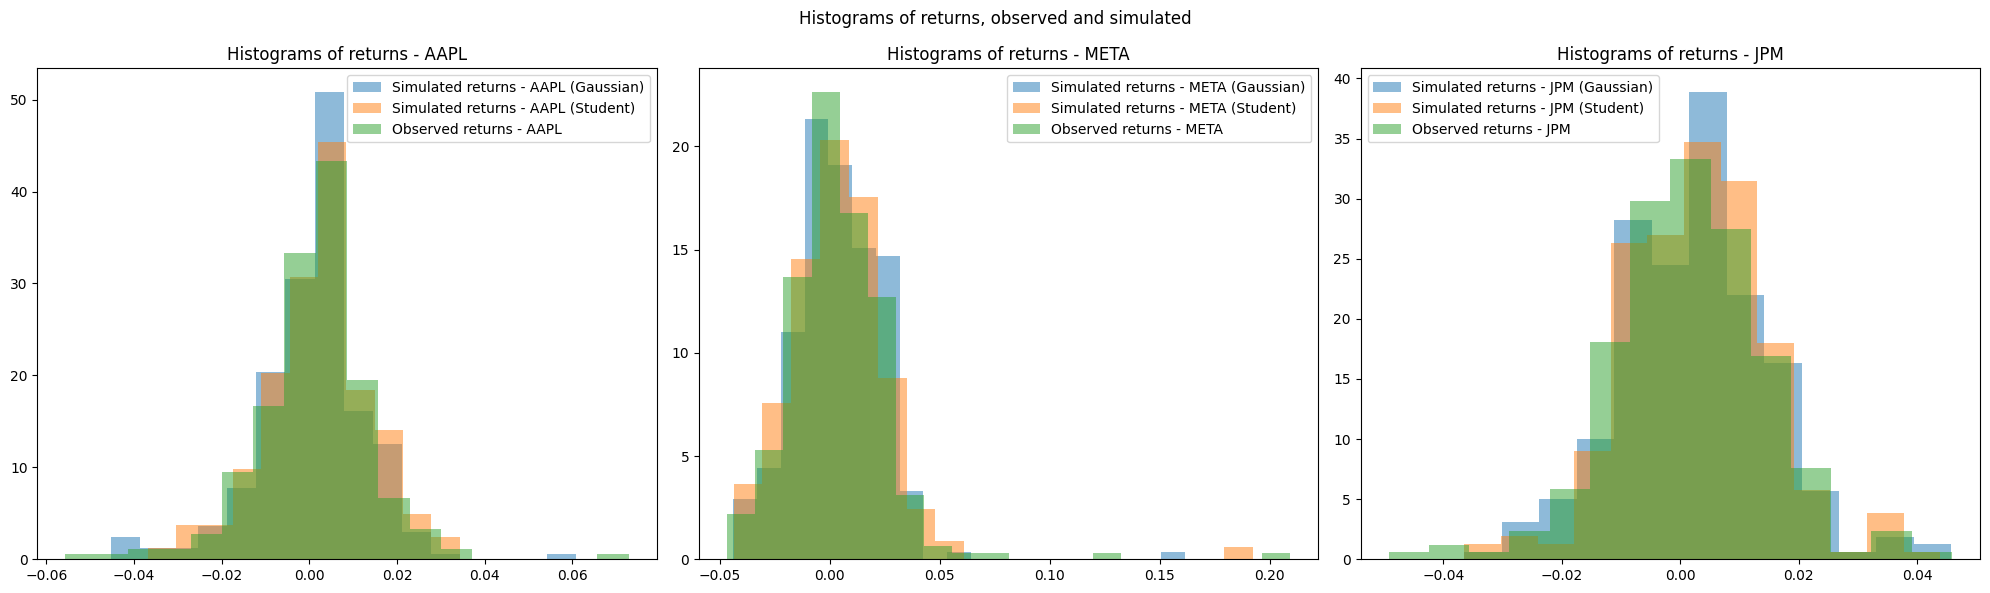

In [41]:
plot_simulated_copulas_results()

### Additional Diagnosis

In [42]:
U, ranks = compute_U_t_i(losses_W)
n_observations = U.shape[0]

In [43]:
def spearman_correlation(ranks: pd.array) -> pd.DataFrame:
    """
    Compute Spearman rank correlation matrix from ranks DataFrame.
    
    Args:
        ranks: DataFrame of ranks with shape (n_observations, n_assets)
    Returns:
        DataFrame of Spearman correlation matrix
    """
    # Convert to DataFrame only for convenience with labels
    if not isinstance(ranks, pd.DataFrame):
        ranks = pd.DataFrame(ranks)

    n, k = ranks.shape
    cols = ranks.columns

    corr = pd.DataFrame(np.eye(k), index=cols, columns=cols)
    values = ranks.to_numpy()

    for i in range(k):
        for j in range(i + 1, k):
            x = values[:, i]
            y = values[:, j]

            # Check for ties
            no_ties = (np.unique(x).size == n) and (np.unique(y).size == n)

            if no_ties:
                d = x - y
                rho = 1 - 6 * np.sum(d ** 2) / (n * (n**2 - 1))
            else:
                # rank transform and Pearson
                rx = pd.Series(x).rank().to_numpy()
                ry = pd.Series(y).rank().to_numpy()
                rho = np.corrcoef(rx, ry)[0, 1]

            corr.iat[i, j] = rho
            corr.iat[j, i] = rho

    return corr

def pvalues_spearman(corr: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Compute approximate p-values for Spearman correlation coefficients 
    using a t-distribution approximation valid for large samples.
    """

    # avoid division by zero when corr = ±1
    corr_clipped = corr.clip(-0.999999, 0.999999)

    # t-statistic approximation
    t_stat = corr_clipped * np.sqrt((n - 2) / (1 - corr_clipped ** 2))

    # p-values (numpy array)
    p_array = 2 * (1 - student_t.cdf(np.abs(t_stat), df=n - 2))

    # convert to DataFrame
    p_vals = pd.DataFrame(p_array, index=corr.index, columns=corr.columns)

    # set diagonal to 0
    np.fill_diagonal(p_vals.values, 0.0)

    return p_vals

In [44]:
corr = spearman_correlation(ranks)
p_vals_spearman = pvalues_spearman(corr, n_observations)
corr, p_vals_spearman

(          0         1         2
 0  1.000000  0.279275  0.343319
 1  0.279275  1.000000  0.589580
 2  0.343319  0.589580  1.000000,
               0         1             2
 0  0.000000e+00  0.000007  2.220713e-08
 1  6.757218e-06  0.000000  0.000000e+00
 2  2.220713e-08  0.000000  0.000000e+00)

In [45]:
def kendall_tau_b(x, y):
    """Kendall's tau-b with two-tailed p-value (supports ties)."""
    n = len(x)
    num_concord = num_discord = 0
    tie_x = tie_y = 0

    for i in range(n - 1):
        for j in range(i + 1, n):
            dx = x[i] - x[j]
            dy = y[i] - y[j]

            if dx == 0 and dy == 0:
                tie_x += 1
                tie_y += 1
            elif dx == 0:
                tie_x += 1
            elif dy == 0:
                tie_y += 1
            else:
                if dx * dy > 0:
                    num_concord += 1
                else:
                    num_discord += 1

    numerator = num_concord - num_discord
    denom_x = math.sqrt((n * (n - 1) / 2) - tie_x)
    denom_y = math.sqrt((n * (n - 1) / 2) - tie_y)
    tau_b = numerator / (denom_x * denom_y)

    var_tau = (4 * n + 10) / (9 * n * (n - 1))
    z = tau_b / math.sqrt(var_tau)

    p_value = 2 * (1 - normal_cdf(abs(z)))
    return tau_b, p_value

def normal_cdf(z):
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))

def kendall_matrix(arr):
    """Compute tau-b and p-values for all column pairs of a 2D array."""
    arr = np.asarray(arr)
    k = arr.shape[1]

    tau_mat = np.zeros((k, k))
    p_mat = np.zeros((k, k))

    for i in range(k):
        for j in range(k):
            if i == j:
                tau_mat[i, j] = 1.0
                p_mat[i, j] = 0.0
            else:
                tau, p = kendall_tau_b(arr[:, i], arr[:, j])
                tau_mat[i, j] = tau
                p_mat[i, j] = p

    return tau_mat, p_mat


In [46]:
tau_matrix, p_matrix = kendall_matrix(ranks)

print("Kendall Tau-b matrix:\n", tau_matrix)
print("\nP-value matrix:\n", p_matrix)

Kendall Tau-b matrix:
 [[1.         0.19578828 0.23638778]
 [0.19578828 1.         0.41744135]
 [0.23638778 0.41744135 1.        ]]

P-value matrix:
 [[0.00000000e+00 3.65850523e-06 2.27108075e-08]
 [3.65850523e-06 0.00000000e+00 0.00000000e+00]
 [2.27108075e-08 0.00000000e+00 0.00000000e+00]]


## **Part 5 - Backtesting Value at Risk and Expected Shortfall for portfolio**

### Portfolio functions

In [47]:
portfolio_losses = 1/3*losses["AAPL"] + 1/3*losses["JPM"] + 1/3*losses["META"]


# If losses has a Date index
# portfolio_df = pd.DataFrame({
#     "Date": losses.index,
#     "portfolio": portfolio_losses.values
# })
portfolio_df = pd.DataFrame({
    "portfolio": portfolio_losses.values
}, index=losses.index)

print(portfolio_df)

            portfolio
Date                 
2023-01-04  -0.013469
2023-01-05   0.004755
2023-01-06  -0.026354
2023-01-09   0.001433
2023-01-10  -0.013395
...               ...
2025-06-23  -0.012580
2025-06-24  -0.008032
2025-06-25  -0.003741
2025-06-26  -0.012621
2025-06-27  -0.001678

[622 rows x 1 columns]


In [48]:
def var_es_copula(losses_W: Dict, alpha: float=0.95, copula_type="Gaussian") -> Tuple[Dict, Dict]:

    res = {col_name: {"VaR": 0.0, "ES": 0.0} for col_name in losses_W.columns}
    
    U_data, _ = compute_U_t_i(losses_W=losses_W)
    copula, _ = fit_copula(U_data=U_data, copula_type=copula_type)

    generated_U = generate_from_copula(U_data=U_data, copula=copula, number_of_samples=1000)

    generated_returns = inverse_transform(U_samples=generated_U, losses_W=losses_W)

    portfolio_losses = -(1/3*generated_returns["AAPL"] + 1/3*generated_returns["META"] + 1/3*generated_returns["JPM"])

    # print(portfolio_losses)
    tmp_losses = pd.DataFrame({
    "portfolio": portfolio_losses.values
    })


    res, param = var_es_historical(losses_W=tmp_losses, alpha=alpha)
    
    return res, param
   
def portfolio_backtest(portfolio_df: pd.DataFrame, losses: pd.DataFrame, alpha: float, methods: pd.DataFrame=["historical", "gaussian", "student", "garch", "fhs", "gaussian_copula", "student_copula"]):
    # methods = ["historical", "gaussian", "student", "garch", "fhs", "gaussian_copula", "student_copula"]
    # alpha = 0.99
    #TICKERS = ["portfolio"]
    results = {"portfolio": { method: {"VaR": [], "ES": []} # results[ticker][method][metric] is a list to append.
                        for method in methods
                        }
                }

    for t in range(W, losses.shape[0]):

        window = portfolio_df.iloc[t - W: t][["portfolio"]]
        # print(window.columns)
        window_all_tickers = losses.iloc[t - W: t]

        
        res_historical, _ = var_es_historical(losses_W=window, alpha=alpha)
        res_gaussian, _ = var_es_gaussian(losses_W=window, alpha=alpha)
        res_student, _ = var_es_student_t(losses_W=window, alpha=alpha)
        res_garch, _ = forecast_var_es_AR_GARCH(losses_W=window, alpha=alpha, p=(7,7, 5))
        res_fhs, _ = forecast_var_es_fhs(losses_W=window, alpha=alpha, p=(7, 7, 5))
        
        res_g_copula, _ = var_es_copula(losses_W=window_all_tickers, alpha=alpha, copula_type="Gaussian");
        res_s_copula, _ = var_es_copula(losses_W=window_all_tickers, alpha=alpha, copula_type="Student");
    

        results["portfolio"]["historical"]["VaR"].append(res_historical["portfolio"]["VaR"])
        results["portfolio"]["historical"]["ES"].append(res_historical["portfolio"]["ES"])

        results["portfolio"]["gaussian"]["VaR"].append(res_gaussian["portfolio"]["VaR"])
        results["portfolio"]["gaussian"]["ES"].append(res_gaussian["portfolio"]["ES"])

        results["portfolio"]["student"]["VaR"].append(res_student["portfolio"]["VaR"])
        results["portfolio"]["student"]["ES"].append(res_student["portfolio"]["ES"])

        results["portfolio"]["garch"]["VaR"].append(res_garch["portfolio"]["VaR"])
        results["portfolio"]["garch"]["ES"].append(res_garch["portfolio"]["ES"])

        results["portfolio"]["fhs"]["VaR"].append(res_fhs["portfolio"]["VaR"])
        results["portfolio"]["fhs"]["ES"].append(res_fhs["portfolio"]["ES"])

        results["portfolio"]["gaussian_copula"]["VaR"].append(res_g_copula["portfolio"]["VaR"])
        results["portfolio"]["gaussian_copula"]["ES"].append(res_g_copula["portfolio"]["ES"])

        results["portfolio"]["student_copula"]["VaR"].append(res_s_copula["portfolio"]["VaR"])
        results["portfolio"]["student_copula"]["ES"].append(res_s_copula["portfolio"]["ES"])

    return results

def plot_var_visualisation(results: Dict, alpha: float=0.95) -> None:
    data = {}

    for ticker, ticker_data in results.items():
        for method, method_data in ticker_data.items():
            for metric, values in method_data.items():
                key = (ticker, method, metric)
                data[key] = values

    df = pd.DataFrame(data)

    # nice multi-level columns
    df.columns = pd.MultiIndex.from_tuples(
        df.columns,
        names=["Ticker", "Method", "Metric"]
    )

    plt.figure(figsize=(20, 6))

    y = portfolio_df["portfolio"][W:]
    x = np.arange(len(y))

    plt.plot(x, losses["META"][W:])

    plt.plot(x, df["portfolio"]["student"]["VaR"], label="Student")
    plt.plot(x, df["portfolio"]["gaussian"]["VaR"], label="gaussian")
    plt.plot(x, df["portfolio"]["historical"]["VaR"], label="historical")
    plt.plot(x, df["portfolio"]["fhs"]["VaR"], label="fhs")
    plt.plot(x, df["portfolio"]["garch"]["VaR"], label="garch")
    plt.plot(x, df["portfolio"]["gaussian_copula"]["VaR"], label="Gaussian copula")
    plt.plot(x, df["portfolio"]["student_copula"]["VaR"], label="Student copula")
    plt.title(f"Portfolio VaR forecasts for alpha={alpha}")
    plt.legend()

In [49]:
res_099 = portfolio_backtest(portfolio_df=portfolio_df, losses=losses, alpha=0.99);

res_095 = portfolio_backtest(portfolio_df=portfolio_df, losses=losses, alpha=0.95);

/home/rafiki/Documents/general/lib/python3.13/site-packages/copulae/stats/_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
/home/rafiki/Documents/general/lib/python3.13/site-packages/copulae/stats/_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
/home/rafiki/Documents/general/lib/python3.13/site-packages/copulae/stats/_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ x_us.T) / df) ** ((dim + df) / 2)
/home/rafiki/Documents/general/lib/python3.13/site-packages/copulae/stats/_multivariate_t.py:79: RuntimeWarning: divide by zero encountered in log
  return np.log(cls.pdf(x, mean, cov, df))
/home/rafiki/Documents/general/lib/python3.13/site-packages/copulae/stats/_multivariate_t.py:116: RuntimeWarning: overflow encountered in power
  c = np.diag(1 + (x_us @ la.inv(cov) @ 

### Univariate models - backtesting

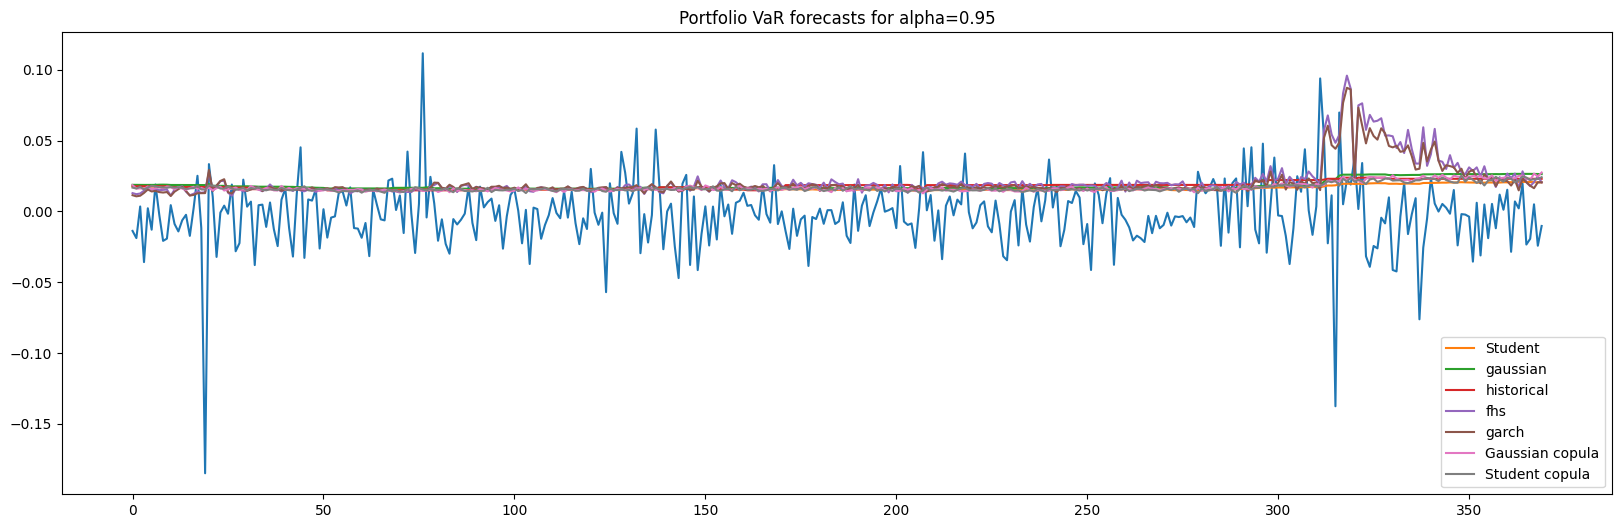

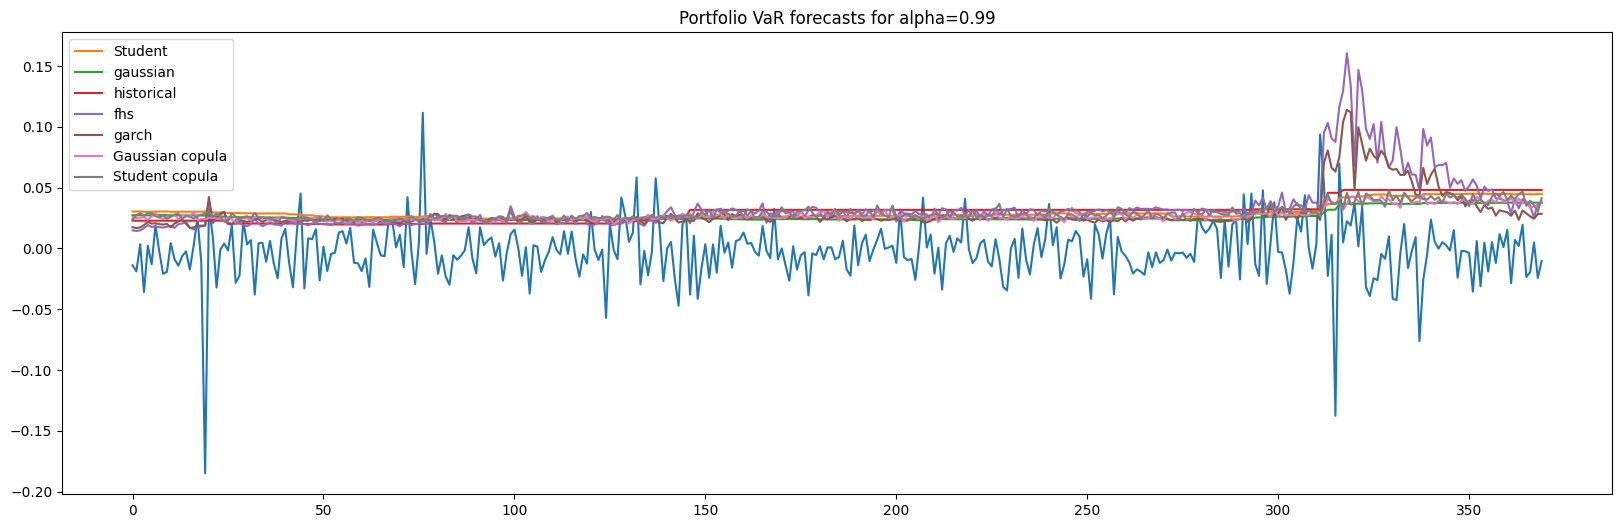

In [50]:
plot_var_visualisation(res_095, 0.95)

plot_var_visualisation(res_099, 0.99)

##### Value at Risk backtest

In [51]:
methods = ["historical", "gaussian", "student", "garch", "fhs"]

df, var_df_095 = backtest_computations(losses=portfolio_df, methods=methods, alphas=[0.95])
df, var_df_099 = backtest_computations(losses=portfolio_df, methods=methods, alphas=[0.99])

In [52]:
var_backtests_095 = run_var_backtests(portfolio_df, var_df_095, alphas=[0.95], methods=methods)
var_backtests_095.sort_values(["Ticker", "Alpha", "Method"])

Ticker      Method  Alpha  N_exceptions    T  Hit_rate    LR_POF  \
4  portfolio         fhs   0.95            21  370  0.056757  0.341395   
3  portfolio       garch   0.95            24  370  0.064865  1.580101   
1  portfolio    gaussian   0.95            24  370  0.064865  1.580101   
0  portfolio  historical   0.95            25  370  0.067568  2.176202   
2  portfolio     student   0.95            27  370  0.072973  3.622796   

      p_POF    LR_ind     p_ind     LR_CC      p_CC  
4  0.559025  0.518138  0.471637  0.859533  0.650661  
3  0.208746  1.236817  0.266085  2.816918  0.244520  
1  0.208746  1.236817  0.266085  2.816918  0.244520  
0  0.140160  0.972025  0.324176  3.148227  0.207191  
2  0.056993  0.545974  0.459967  4.168770  0.124384

In [53]:
var_backtests_099 = run_var_backtests(portfolio_df, var_df_099, alphas=[0.99], methods=methods)
var_backtests_099.sort_values(["Ticker", "Alpha", "Method"])

Ticker      Method  Alpha  N_exceptions    T  Hit_rate     LR_POF  \
4  portfolio         fhs   0.99             8  370  0.021622   3.788416   
3  portfolio       garch   0.99            11  370  0.029730   9.516832   
1  portfolio    gaussian   0.99            13  370  0.035135  14.310172   
0  portfolio  historical   0.99            10  370  0.027027   7.394026   
2  portfolio     student   0.99            11  370  0.029730   9.516832   

      p_POF    LR_ind     p_ind      LR_CC      p_CC  
4  0.051608  0.354600  0.551521   4.143016  0.125996  
3  0.002036  0.973624  0.323778  10.490456  0.005273  
1  0.000155  0.526175  0.468219  14.836347  0.000600  
0  0.006544  1.266863  0.260356   8.660889  0.013162  
2  0.002036  0.973624  0.323778  10.490456  0.005273

##### Expected Shortfall backtest

In [54]:
p_es_portfolio, _, _, _, _, _ = run_es_backtest(portfolio_df, models=methods, alphas=[0.95, 0.99])
p_es_portfolio

{'0.95': {'historical': {'portfolio': {np.float64(0.013000000000000001)}},
  'gaussian': {'portfolio': {np.float64(0.0)}},
  'student': {'portfolio': {np.float64(0.047)}},
  'garch': {'portfolio': {np.float64(0.0)}},
  'fhs': {'portfolio': {np.float64(0.033)}}},
 '0.99': {'historical': {'portfolio': {np.float64(0.10149942329873127)}},
  'gaussian': {'portfolio': {np.float64(0.005537098560354374)}},
  'student': {'portfolio': {np.float64(0.22936763129689175)}},
  'garch': {'portfolio': {np.float64(0.006444683136412459)}},
  'fhs': {'portfolio': {np.float64(0.008168028004667444)}}}}

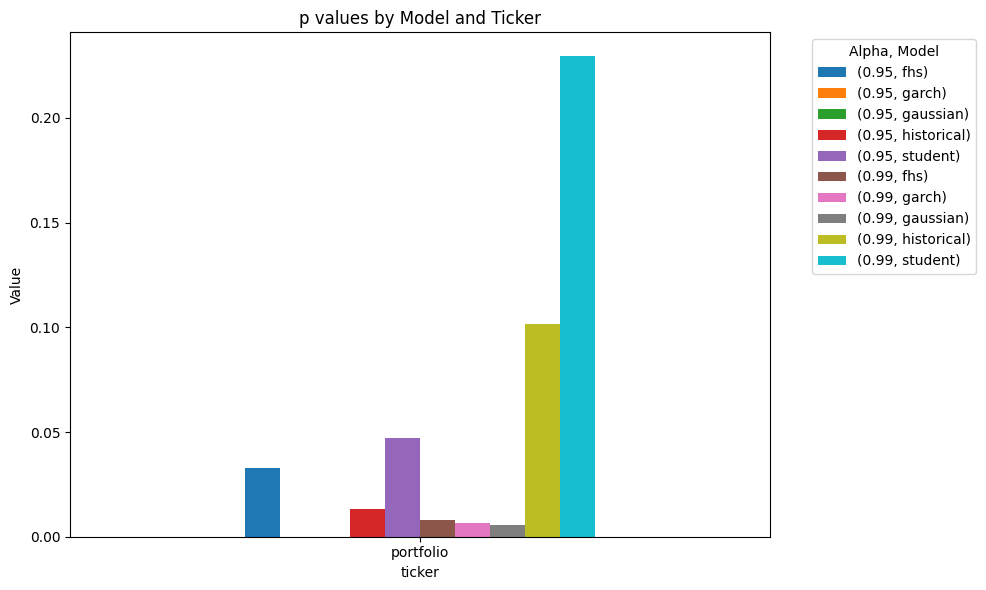

In [55]:
plot_es_p_values(p=p_es_portfolio)

In [56]:
r_portfolio = ranking(p_es_portfolio, var_backtests_099, var_backtests_095, tickers=["portfolio"])
r_portfolio

{'0.95': {'historical': {'portfolio': np.float64(0.12011705483613022)},
  'garch': {'portfolio': np.float64(0.15108866674815855)},
  'student': {'portfolio': np.float64(0.07612552579921544)},
  'gaussian': {'portfolio': np.float64(0.15108866674815855)},
  'fhs': {'portfolio': np.float64(0.41422875834678247)}},
 '0.99': {'historical': {'portfolio': np.float64(0.04040173597398514)},
  'garch': {'portfolio': np.float64(0.004584419649052101)},
  'student': {'portfolio': np.float64(0.07889206903587853)},
  'gaussian': {'portfolio': np.float64(0.0020974559504767726)},
  'fhs': {'portfolio': np.float64(0.06192405098153849)}}}

### Copulas approach

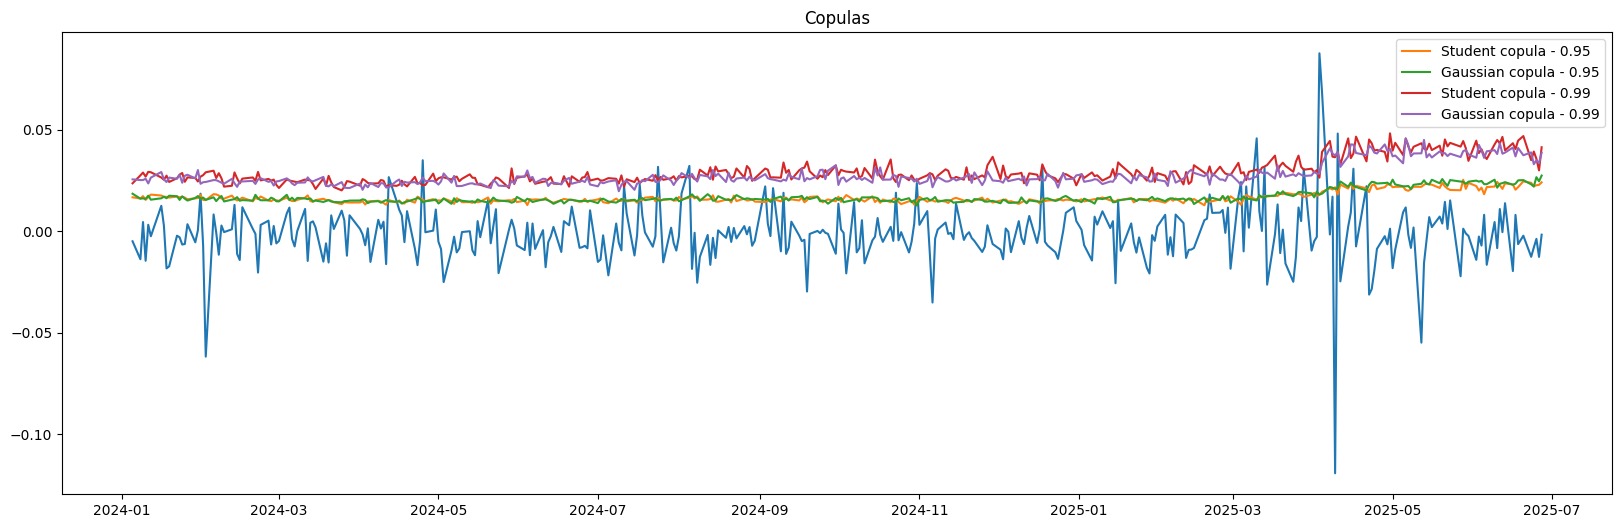

In [57]:
plt.figure(figsize=(20,6))
plt.plot(portfolio_losses[W:])
x = portfolio_losses.index[W:]

plt.plot(x, res_095["portfolio"]["student_copula"]["VaR"], label="Student copula - 0.95")
plt.plot(x, res_095["portfolio"]["gaussian_copula"]["VaR"], label="Gaussian copula - 0.95")

plt.plot(x, res_099["portfolio"]["student_copula"]["VaR"], label="Student copula - 0.99")
plt.plot(x, res_099["portfolio"]["gaussian_copula"]["VaR"], label="Gaussian copula - 0.99")

plt.title("Copulas")
plt.legend()

### Backtesting comparisons

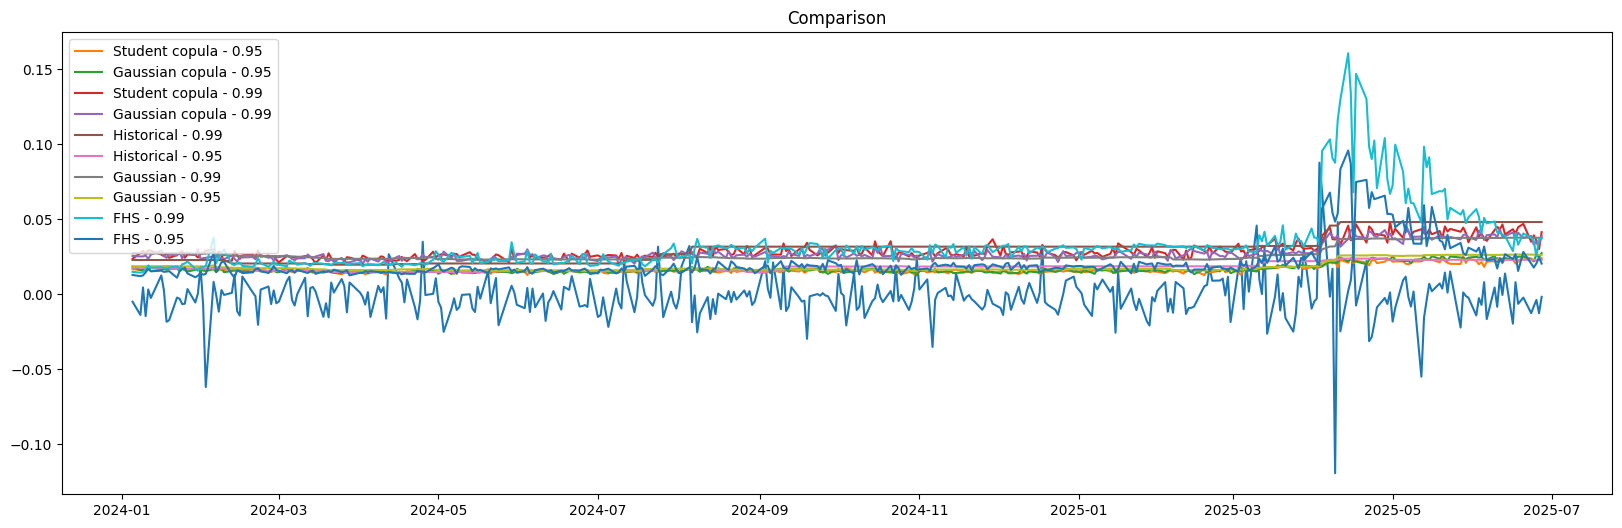

In [58]:
plt.figure(figsize=(20,6))
plt.plot(portfolio_losses[W:])
x = portfolio_losses.index[W:]

plt.plot(x, res_095["portfolio"]["student_copula"]["VaR"], label="Student copula - 0.95")
plt.plot(x, res_095["portfolio"]["gaussian_copula"]["VaR"], label="Gaussian copula - 0.95")

plt.plot(x, res_099["portfolio"]["student_copula"]["VaR"], label="Student copula - 0.99")
plt.plot(x, res_099["portfolio"]["gaussian_copula"]["VaR"], label="Gaussian copula - 0.99")

plt.plot(x, res_099["portfolio"]["historical"]["VaR"], label="Historical - 0.99")
plt.plot(x, res_095["portfolio"]["historical"]["VaR"], label="Historical - 0.95")

plt.plot(x, res_099["portfolio"]["gaussian"]["VaR"], label="Gaussian - 0.99")
plt.plot(x, res_095["portfolio"]["gaussian"]["VaR"], label="Gaussian - 0.95")

plt.plot(x, res_099["portfolio"]["fhs"]["VaR"], label="FHS - 0.99")
plt.plot(x, res_095["portfolio"]["fhs"]["VaR"], label="FHS - 0.95")
plt.title("Comparison")
plt.legend()